<a href="https://colab.research.google.com/github/sangttruong/IncomeVis/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Technical Appendix for Visualizing Income Inequality in the United States**

*Author: Sang Truong and Dr. Humberto Barreto*

Department of Economics and Management

DePauw University, Greencastle, IN 46135


## **Section 1. Introduction**

Information about the distribution of income is communicated by numbers and statistics (e.g., the Gini coefficient). This can be difficult to understand and often requires specialized knowledge. Our goal is to provide a novel, eye-catching visual display of the income distribution in the United States that conveys fundamental information about the evolution and current level of income inequality. We use IPUMS CPS data to create household income deciles for each of the 51 states and DC from 1978 to 2018. Plotting these data gives a 3D chart that provides a startling picture of income differences within and across states.

This notebook records all important steps to transform, compress, and visualize raw from IPUMS-CPS.

Before getting start, we import some important libraries, such as pandas for data manipulation and analysis, numpy for scientific computing, sklearn for statistical analysis, matplotlib for visualization, and color for color gradient. We also mount Google Drive to Google Colab so that all of analyses are conduct online.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Unlike other packages, colour is not available in the system, therefore, requires installation.
# !apt install cuda
# !pip install colour
# from colour import Color

from collections import OrderedDict
from google.colab import drive
from sklearn.linear_model import LinearRegression

drive.mount('/content/gdrive')
in_path = 'gdrive/My Drive/Colab Notebooks/USIncomeVis/input/'
out_path = 'gdrive/My Drive/Colab Notebooks/USIncomeVis/output/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Data for our analysis can be downloaded from [IPUMS-CPS](https://cps.ipums.org/cps/) and [IPUMS-USA](https://usa.ipums.org/usa). We download all one sample for all available year for both database. Detail about samples as well as variables can be found on IPUMS website.

**Reference:**

Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles and J. Robert Warren. Integrated Public Use Microdata Series, Current Population Survey: Version 6.0 [dataset]. Minneapolis, MN: IPUMS, 2018.
https://doi.org/10.18128/D030.V6.0

Steven Ruggles, Sarah Flood, Ronald Goeken, Josiah Grover, Erin Meyer, Jose Pacas and Matthew Sobek. IPUMS USA: Version 9.0 [dataset]. Minneapolis, MN: IPUMS, 2019.
https://doi.org/10.18128/D010.V9.0

For IPUMS-CPS, most variables are available annually. All seleced sample are ASEC sample. From 1962 to 1967, persons under age 14 not included in sample.

In [2]:
# Import raw data
raw = pd.read_csv(in_path + "ipums-cps.csv")
raw.head(5)

,YEAR,HFLAG,ASECWTH,CPI99,STATEFIP,HHINCOME,PERNUM,ASECWT,AGE,SEX,RACE,HISPAN,EDUC,INCTOT,INCWAGE
0,1962,NaN,1494.99,5.572,61,NaN,1,1494.99,18,2,100,NaN,72.0,0,0
1,1962,NaN,1568.53,5.572,61,NaN,1,1568.53,14,1,100,NaN,31.0,99999999,9999999
2,1962,NaN,6443.03,5.572,42,NaN,1,6443.03,72,1,100,NaN,40.0,99999999,9999999
3,1962,NaN,1473.97,5.572,25,NaN,1,1473.97,29,1,100,NaN,72.0,1692,1692
4,1962,NaN,1538.21,5.572,25,NaN,1,1538.21,21,1,100,NaN,50.0,1522,1522


We copy CPI99 and YEAR to a different dataframe for later analysis to avoid losing information by data cleaning for HHINCOME. 

In [0]:
# Extract CPI
CPI = raw[['CPI99', 'YEAR']]
CPI.head(10)
CPI.set_index('YEAR', inplace = True)

Our unit of analysis is household. Thus, to visualize household income, our main variable is household income (HHINCOME). This variable is only available annually since 1968. We exclude observations that does not have household income. 

In [4]:
raw = raw[pd.notnull(raw.HHINCOME)]
raw.head(5)

,YEAR,HFLAG,ASECWTH,CPI99,STATEFIP,HHINCOME,PERNUM,ASECWT,AGE,SEX,RACE,HISPAN,EDUC,INCTOT,INCWAGE
415399,1968,NaN,1163.22,4.988,70,18800.0,1,1163.22,28,1,100,NaN,73.0,18800,0
415400,1968,NaN,1163.22,4.988,70,18800.0,2,1163.22,28,2,100,NaN,80.0,0,0
415401,1968,NaN,1163.22,4.988,70,18800.0,3,1118.27,4,2,100,NaN,1.0,99999999,9999999
415402,1968,NaN,1163.22,4.988,70,18800.0,4,1166.43,3,1,100,NaN,1.0,99999999,9999999
415403,1968,NaN,1254.56,4.988,70,1692.0,1,1254.56,71,2,100,NaN,110.0,1692,0


According to IPUMS-CPS: "STATEFIP is comparable for 1963-1967 and 1977 onward, years in which each state and the District of Columbia were separately identified. In the remaining years, two or more states share the same code, and these groupings change over time. In 1962, 8 states cannot be separately identified. In 1968-1972, 32 states cannot be separately identified, and in 1973-1976, 38 states cannot be separately identified. In these years, up to 5 states share the same code." Therefore, we only keep the data after from 1977.

**Reference:** https://cps.ipums.org/cps-action/variables/statefip#comparability_section

In [5]:
raw = raw[raw.YEAR >= 1977]
raw.head(5)

,YEAR,HFLAG,ASECWTH,CPI99,STATEFIP,HHINCOME,PERNUM,ASECWT,AGE,SEX,RACE,HISPAN,EDUC,INCTOT,INCWAGE
1685415,1977,NaN,856.04,2.928,23,11500.0,1,856.04,48,2,100,0.0,110.0,11500,11000
1685416,1977,NaN,856.04,2.928,23,11500.0,2,803.60,15,1,100,0.0,32.0,0,0
1685417,1977,NaN,856.04,2.928,23,44310.0,1,856.04,47,1,100,0.0,122.0,38800,0
1685418,1977,NaN,856.04,2.928,23,44310.0,2,856.04,45,2,100,0.0,72.0,4000,4000
1685419,1977,NaN,856.04,2.928,23,44310.0,3,814.43,19,2,100,0.0,80.0,670,670


"The Census Bureau fielded the CPS 2014 ASEC sample using an experimental redesign. All respondents received new health insurance questions, but 3/8ths of the total sample was randomly selected to receive the redesigned income questions. The larger portion of the sample (5/8) was given the existing questions on income. The redesign attempted to address income under-reporting, in particular, retirement, pensions, annuities, and government cash-transfer programs. More accurate income reporting in turn allows for better measurement of poverty statistics."

HFLAG = 0 indicates 5/8 sample, and HFLAG = 1 indicate 3/8 sample in 2014. For the 2014 to be compatible with other data year, we select HFLAG = 0.

**Reference:** https://cps.ipums.org/cps/three_eighths.shtml).

In [6]:
# Select data with HFLAG != 1 and then drop HFLAG
raw = raw[raw.HFLAG !=1]
raw = raw.drop(columns = ['HFLAG'])
raw.head(5)

,YEAR,ASECWTH,CPI99,STATEFIP,HHINCOME,PERNUM,ASECWT,AGE,SEX,RACE,HISPAN,EDUC,INCTOT,INCWAGE
1685415,1977,856.04,2.928,23,11500.0,1,856.04,48,2,100,0.0,110.0,11500,11000
1685416,1977,856.04,2.928,23,11500.0,2,803.60,15,1,100,0.0,32.0,0,0
1685417,1977,856.04,2.928,23,44310.0,1,856.04,47,1,100,0.0,122.0,38800,0
1685418,1977,856.04,2.928,23,44310.0,2,856.04,45,2,100,0.0,72.0,4000,4000
1685419,1977,856.04,2.928,23,44310.0,3,814.43,19,2,100,0.0,80.0,670,670


For IPUMS-USA, most variables are available (mostly) decennial from 1960 to 2000 an yearly from 2000 to 2017. For sample from 2000 to 2017, we select *ACS* sample. For 1990 and 1980, we select *5% state sample*. For 1970, we select *1% state fml* sample. Before 1960, we select *1%* sample.

In [7]:
raw_rent = pd.read_csv(in_path + "ipums-usa.csv")
raw_rent.head(5)

,YEAR,HHWT,STATEFIP,RENTGRS,PERNUM,PERWT,RELATE,RELATED
0,1850,97.0,1,NaN,1,97.0,1,101
1,1850,97.0,1,NaN,2,97.0,2,201
2,1850,97.0,1,NaN,3,97.0,3,301
3,1850,97.0,1,NaN,4,97.0,3,301
4,1850,97.0,1,NaN,5,97.0,3,301


The main variable for ```raw_rent``` is gross rent (RENTGRS). We exclude obsevation with missing RENTGRS values. As we see below, RENTGRS is only available from 1960.

In [8]:
raw_rent = raw_rent[pd.notnull(raw_rent.RENTGRS)]
raw_rent.head(5)

,YEAR,HHWT,STATEFIP,RENTGRS,PERNUM,PERWT,RELATE,RELATED
8586817,1960,100.0,6,175.0,1,100.0,1,101
8586818,1960,100.0,6,175.0,2,100.0,2,201
8586819,1960,100.0,6,110.0,1,100.0,1,101
8586820,1960,100.0,6,110.0,2,100.0,2,201
8586821,1960,100.0,6,110.0,3,100.0,3,301


Our unit of analysis is household. The unit of ```raw_housing``` dataframe is person. Therefore, we only use information of household head (RELATE = 1) for further analysis. In addition, we select individual with positive monthly gross rent (RENTGRS) for further analysis.

In [0]:
# Eliminate RENTGRS = 0
raw_rent = raw_rent[raw_rent.RENTGRS > 0]

# Select the household head
raw_rent = raw_rent[raw_rent.RELATE == 1]

We generate list of states code that we will work with. ```statefip``` is derived from variable STATEFIP from IPUMS-CPS and ```year_usa``` is dirived from variable YEAR from IPUMS-USA. ```year_cps``` derived from variable YEAR from IPUMS-CPS. Mathematically,

$$ year\_usa = \{1850, 1860, ..., 1880, 1900, 1910, ..., 2000, 2001, ..., 2017\}$$
$$ year\_cpi = \{1977, 1978, ..., 2019\}$$
$$ pred\_year = \{x | x \in year\_cps, x \notin year\_usa\} $$

These ranges were created in attempt to handle all missing data in range [1978, 2019], in which HHINCOME is available *and* STATEFIP is comparable. 

In [0]:
# Year
year_usa = list(set(raw_rent.YEAR))
year_cps = list(set(raw.YEAR))
pred_year = list(np.setdiff1d(year_cps, year_usa))

# States
statefip = list(set(raw.STATEFIP))
state_name = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
              'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
              'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
              'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
              'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
              'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
              'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
              'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
              'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
              'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

# Color interpolation
# red = Color("red")
# colors = list(red.range_to(Color("green"),len(statefip)))
# colors = pd.DataFrame(data = colors, index = statefip)
# colors.rename(columns = {0: 'Color'}, inplace = True)

colors = ["#FF0000", "#FF0A00", "#FF1400", "#FF1E00", "#FF2800", "#FF3300", "#FF3D00",
          "#FF4700", "#FF5100", "#FF5B00", "#FF6600", "#FF7000", "#FF7A00", "#FF8400",
          "#FF8E00", "#FF9900", "#FFA300", "#FFAD00", "#FFB700", "#FFC100", "#FFCC00",
          "#FFD600", "#FFE000", "#FFEA00", "#FFF400", "#FFFF00", "#F4FF00", "#EAFF00",
          "#E0FF00", "#D6FF00", "#CCFF00", "#C1FF00", "#B7FF00", "#ADFF00", "#A3FF00",
          "#99FF00", "#8EFF00", "#84FF00", "#7AFF00", "#70FF00", "#66FF00", "#5BFF00",
          "#51FF00", "#47FF00", "#3DFF00", "#32FF00", "#28FF00", "#1EFF00", "#14FF00",
          "#0AFF00", "#00FF00"]
colors = pd.DataFrame(colors, columns = ['Color'], index = statefip)

## **Section 2. Deflator generator**

In this analysis, we employ 3 deflators, namely Cost Of Living Index (COLI), Consumer Price Index (CPI), and household size (HHSIZE) 

* It does not quite make sense to compare income of a person in Indiana with a person in California, simply because it is significantly more expensive to live in California. To account for this difference, we deflate income with Cost of Living Index (COLI) deflator.

* 100 dollars last 10 years is not equal to 100 dollars today due to inflation. To compare incomes overtime, we need to converge them to the same unit (specifically, in this analysi we use 2018 dollars). We achieve this goal by using Consumer Price Index (CPI) deflator.

* Our unit of analysis is household. It does not make so much sense to compare income of a 12-people household and a 2-people household. Therefore, we normalize the household income with household size. 

### **2.1. Cost Of Living Index**

Housing cost is the key variable in variation in state cost of living. We assume prices of all other goods the same across states.

Housing cost (including utilities) is roughly 44% of budget. “The estimate of 44 percent came from the Consumer Expenditure survey tabulations of expenditures for two‐adult/two‐child families. For families at the 35th percentile of the distribution of spending on food, housing and clothing, housing represented 44 percent of total expenditures assuming miscellaneous expenditures are set at 15 percent of the food, housing and clothing amount.” (Renwick, 2001, p. 4)

The [C2ER COLI](https://coli.org/) uses these budget weights (personal correspondence), with Housing and Utilities about 38%. 

Our state COLI is a Laspeyres index:

$$ COLI_s =\frac{ P_{H,s}H + P_{X}X }{ \overline{P_{H}}H + \overline{P_{X}}X}$$ 

All other goods, X, have the same price across states so we set $P_X = 1$ for all states and we can normalize all housing prices to 1.0 so both prices in the denominator are also one. We can then incorporate the housing budget share information to get:

$$ COLI_s =\frac{ 0.44 P_{H,s} + 0.56 }{0.44 + 0.56} = 0.44 P_{H,s} + 0.56  $$ 

ACS and 5% state samples in IPUMS USA has RENTGRS which includes utilities and fuels in monthly contract rent.

We will use the median of RENTGRS (including the sample weights for each household, HHWT) for each state divided by the overall average median as our value of $P_{H,s}$. After that, we compute the COLI for each state as $0.44 P_{H,s} + 0.56$.

We store the final COLI deflator in a dataframe called ```COLI```, whom columns are years in ```year_usa``` and rows are states in ```statefip```.

In [0]:
# Generate COLI grid
# COLI = pd.DataFrame(columns = year_usa, index = statefip) # For linear regression
COLI = pd.DataFrame(columns = np.arange(1960,2020), index = statefip) # For interpolation

We will fill out ```COLI``` column by column (in other words, year by year). To represent the gross rent for each state each year, we consider using mean and median of gross rent (RENTGRS). We observe that mean and median of gross rent for each state over time is not too different than each other, as shown in their summary statistics for Alabama and Delaware (for example).

In [91]:
# Alabama
state1 = raw_rent[raw_rent.STATEFIP == 1]
meanRENTGRS1 = state1.groupby(state1['YEAR'])['RENTGRS'].mean()
meanRENTGRS1sum = pd.DataFrame(meanRENTGRS1.describe())
meanRENTGRS1sum.rename(columns={'RENTGRS':'Mean1'}, inplace = True)

medianRENTGRS1 = state1.groupby(state1['YEAR'])['RENTGRS'].median()
medianRENTGRS1sum = pd.DataFrame(medianRENTGRS1.describe())
medianRENTGRS1sum.rename(columns={'RENTGRS':'Median1'}, inplace = True)

# Delaware
state10 = raw_rent[raw_rent.STATEFIP == 10]
meanRENTGRS10 = state10.groupby(state10['YEAR'])['RENTGRS'].mean()
meanRENTGRS10sum = pd.DataFrame(meanRENTGRS10.describe())
meanRENTGRS10sum.rename(columns={'RENTGRS':'Mean10'}, inplace = True)

medianRENTGRS10 = state10.groupby(state10['YEAR'])['RENTGRS'].median()
medianRENTGRS10sum = pd.DataFrame(medianRENTGRS10.describe())
medianRENTGRS10sum.rename(columns={'RENTGRS':'Median10'}, inplace = True)

# Descriptive statistics
summary1_10 = pd.concat([meanRENTGRS1sum, medianRENTGRS1sum, meanRENTGRS10sum, medianRENTGRS10sum], axis = 1)
summary1_10

,Mean1,Median1,Mean10,Median10
count,22.000000,22.000000,22.000000,22.000000
mean,557.039168,520.500000,795.267943,762.022727
std,214.750333,199.520735,307.477105,292.335525
min,49.660537,45.000000,79.123037,75.000000
25%,520.070862,488.750000,713.683138,676.875000
50%,616.137718,573.000000,893.931527,860.000000
75%,700.856675,653.375000,1007.295921,967.500000
max,773.129292,720.000000,1098.924338,1055.000000


Indeed, over year, mean and median of gross rent of Alabama and Delaware move together.

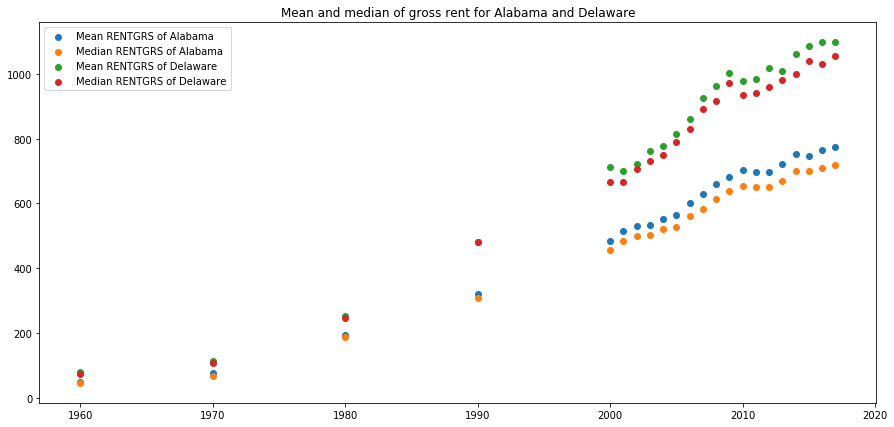

In [92]:
plt.figure(figsize=(15,7))
plt.scatter(year_usa, meanRENTGRS1, label = "Mean RENTGRS of Alabama")
plt.scatter(year_usa, medianRENTGRS1, label = "Median RENTGRS of Alabama")
plt.scatter(year_usa, meanRENTGRS10, label = "Mean RENTGRS of Delaware")
plt.scatter(year_usa, medianRENTGRS10, label = "Median RENTGRS of Delaware")
plt.legend()
plt.title("Mean and median of gross rent for Alabama and Delaware")
plt.show()

In this analysis, we choose to use median of gross rent due to a large amount of outlier showing in the box and whiskers plot below. For example, for Alabama and Delaware, the box and whiskers plot below shows that a significant amount of data is out of upper whister.

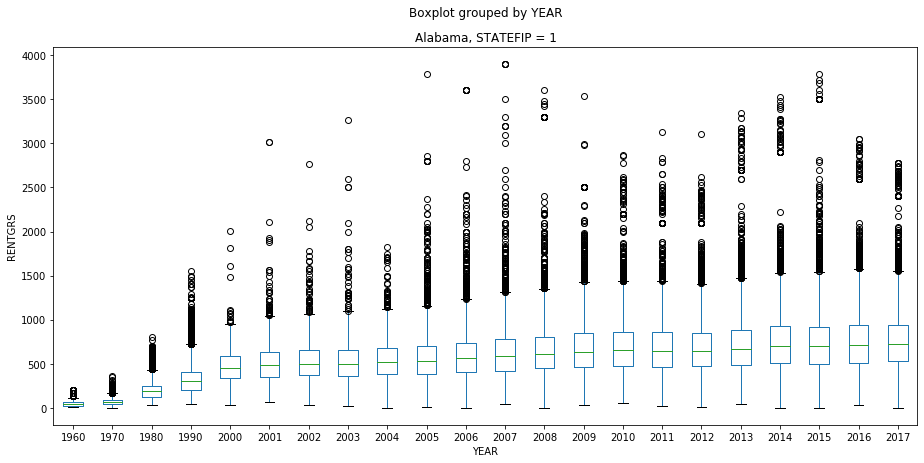

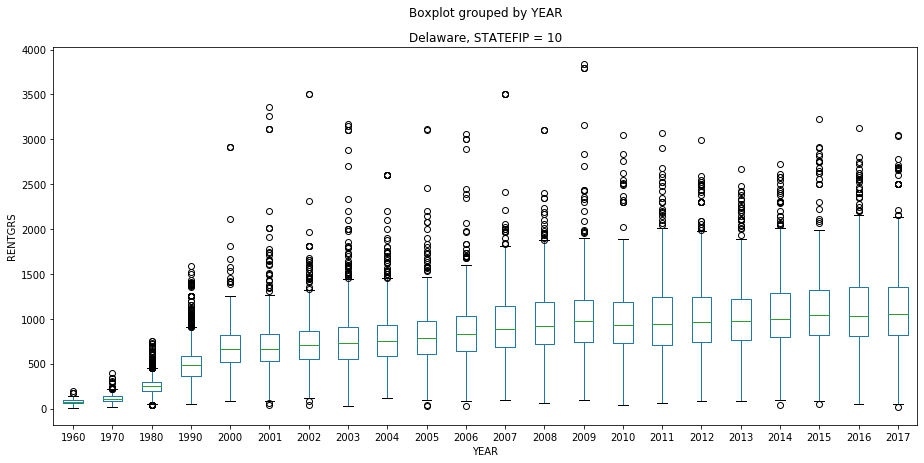

In [93]:
state1.boxplot(column='RENTGRS', by = 'YEAR', grid = False, figsize = (15,7), showfliers = True) # This is Pandas boxplot
plt.title('Alabama, STATEFIP = 1')
plt.xlabel('YEAR')
plt.ylabel('RENTGRS')

state10.boxplot(column='RENTGRS', by = 'YEAR', grid = False, figsize = (15,7))
plt.title('Delaware, STATEFIP = 10')
plt.xlabel('YEAR')
plt.ylabel('RENTGRS')
plt.show()

Due to a very small different between mean and median of gross rent, we think the final result will not be practically different if we choose to use mean of gross rent instead of median of gross rent. The calculation is performed as below. After computing the median of gross grow, we estimate the cost of living for each state with the assumption that the price of other good is the same across states.

In [0]:
# Iterate through each year in yearList
for y in year_usa:
  # Extract housing data for each year
  rent_y = raw_rent[raw_rent.YEAR == y]
  # Compute the median gross rent for each state
  COLI[y] = rent_y.groupby(rent_y['STATEFIP'])['RENTGRS'].median()

# Compute COLI
COLI = 0.44*COLI + 0.56

In [95]:
COLI.head(5)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
1,20.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.76,213.96,220.56,221.44,229.36,232.88,247.84,257.52,270.28,281.06,288.32,286.56,287.22,295.36,308.56,309.00,312.96,317.36,NaN,NaN
2,59.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.96,334.96,344.86,352.56,361.36,351.02,369.50,387.76,392.16,400.96,419.88,418.56,427.36,440.56,471.36,471.36,484.56,480.16,NaN,NaN
4,29.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.40,290.96,293.60,301.52,312.96,317.36,338.48,356.96,375.88,374.56,365.76,361.36,378.96,387.76,396.56,406.02,422.96,440.56,NaN,NaN
5,20.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.94,222.76,220.56,227.16,231.78,232.44,244.32,251.36,261.04,258.62,268.96,260.38,269.40,282.16,284.14,293.16,290.96,298.44,NaN,NaN
6,33.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,271.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,345.96,367.96,378.96,400.96,414.16,427.36,449.36,466.96,493.36,502.16,506.56,502.16,510.96,537.36,552.32,572.56,599.84,638.56,NaN,NaN


... and its visualization (each color is a state)...


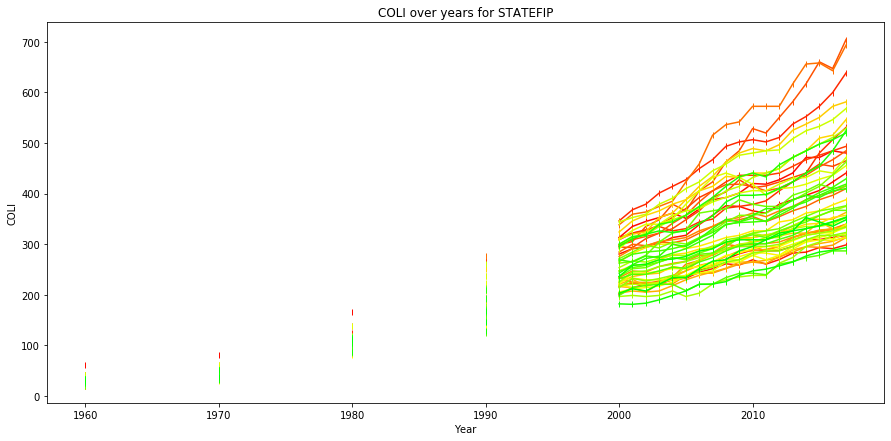

In [96]:
# Plott COLI for each state
plt.figure(figsize = (15,7))
for i in statefip:
  # x = plt.plot(year_usa, COLI.loc[i], c = str(colors.loc[i,'Color']), marker = '|') # For linear regression
  x = plt.plot(np.arange(1960,2020), COLI.loc[i], c = str(colors.loc[i,'Color']), marker = '|') # For interpolation

plt.title('COLI over years for STATEFIP')
plt.xlabel('Year')
plt.ylabel('COLI')
plt.show()

As show above, for most states from 1970 to 2018, COLI grows linearly. We observe that there are states for which COLI growth nonlinearly (maybe exponentially or polinomially). To infer the missing value between 1970 and 2000, there was temptation to fit a quandratic model (i.e. $COLI = f(YEAR, YEAR^2)$ with our data instead of just a linear model (i.e. $COLI = f(YEAR)$). However, since for most states, COLI express linear growth behavior, we decide to use simple yet effective linear model for each state.

Before conducting the regression, it is convinient to transpose the COLI dataframe, so that each column is a state.

In [97]:
COLI=COLI.T
COLI.head(10)

,1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56
1960,20.36,59.96,29.16,20.36,33.56,33.56,33.56,33.56,40.16,33.56,24.76,33.56,29.16,40.16,33.56,29.16,29.16,24.76,24.76,29.16,33.56,33.56,33.56,33.56,20.36,29.16,29.16,29.16,40.16,29.16,40.16,33.56,33.56,24.76,29.16,33.56,24.76,29.16,29.16,29.16,20.36,29.16,24.76,24.76,29.16,29.16,33.56,33.56,24.76,33.56,29.16
1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Linear regression is performed as below. The result shows that for most states, $R^2$ are very closed to 1, and none of the $R^2$ is under 80%.

In [0]:
# Generate regression grid
reg = pd.DataFrame(index = statefip, columns = [['Coefficient', 'Intercept', 'Rsquared']])

# Generate COLI prediction grid
predCOLI = pd.DataFrame(columns = statefip, index = pred_year)

# Convert pred_year and year_usa to 2D array for sklearn
pred_year_2D = np.reshape(pred_year, (-1,1))
year_usa_2D = np.reshape(year_usa, (-1,1))

# Create instance of class
model = LinearRegression()

# Regress deflator on year
for i in statefip:
  model.fit(year_usa_2D, COLI[i])
  reg.loc[i, 'Coefficient'] = model.coef_.item(0)
  reg.loc[i, 'Intercept'] = model.intercept_
  reg.loc[i, 'Rsquared'] = model.score(year_usa_2D, COLI[i])
  predCOLI[i] = model.predict(pred_year_2D)

# Visualize Rsquared
plt.figure(figsize=(15,7))
plt.xlabel('STATEFIP')
plt.ylabel('$R^2$')
r2 = (reg[['Rsquared']].values).flatten()
plt.bar(statefip, r2)

We merge the inferred COLI with the available COLI. For every year, COLI will be normalized by the average COLI across the states. Finally, we drop year 1970 to have the final COLI dataframe as shown below (first 10 lines).

In [0]:
# Concatinate available data and inferred data
COLI = pd.concat([COLI, predCOLI])
COLI = COLI.sort_index()

# Compute average COLI
avgCOLI = COLI.mean(axis = 1)
avgCOLI = pd.DataFrame(avgCOLI)
avgCOLI = avgCOLI.rename(columns = {0: "AVG_COLI"})

# Normalize COLI by average COLI by year
for y in year_cps: 
  COLI.loc[y] = COLI.loc[y]/avgCOLI.loc[y,'AVG_COLI']

# Drop year = [1960, 1970]
COLI.drop(index = [1960, 1970], inplace = True )

COLI

,1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56
1977,0.772318,1.450699,1.090031,0.807407,1.318247,1.072624,1.251662,1.134123,0.999301,1.160598,1.026369,1.258392,0.868806,1.119625,0.960448,0.856802,0.868104,0.782793,0.820953,0.929415,1.163410,1.250166,1.040126,1.060124,0.767847,0.904458,0.809892,0.861678,1.342583,1.180960,1.311818,0.869594,1.102771,0.934105,0.754488,0.972019,0.845718,1.022933,0.937776,1.063760,0.889277,0.800957,0.862542,0.986295,0.967306,0.986234,1.128182,1.081625,0.715479,1.011254,0.825905
1978,0.774430,1.427614,1.087604,0.803354,1.330291,1.080329,1.249518,1.136778,1.041474,1.161810,1.025323,1.286548,0.865994,1.111225,0.951036,0.848143,0.864135,0.780915,0.825813,0.923329,1.181155,1.253199,1.027687,1.050750,0.769874,0.897759,0.807210,0.856850,1.327377,1.179145,1.316427,0.868368,1.114558,0.932910,0.751546,0.960816,0.841710,1.025142,0.936214,1.064169,0.890928,0.793115,0.862377,0.988585,0.970066,0.988642,1.138062,1.088107,0.714276,1.000147,0.827166
1979,0.776288,1.407314,1.085470,0.799789,1.340882,1.087105,1.247633,1.139113,1.078559,1.162876,1.024403,1.311308,0.863522,1.103838,0.942758,0.840528,0.860645,0.779264,0.830088,0.917977,1.196759,1.255867,1.016748,1.042507,0.771656,0.891868,0.804852,0.852605,1.314005,1.177549,1.320481,0.867290,1.124923,0.931859,0.748959,0.950964,0.838186,1.027084,0.934840,1.064528,0.892380,0.786220,0.862233,0.990599,0.972493,0.990760,1.146749,1.093807,0.713218,0.990380,0.828274
1980,0.803144,1.596643,1.117149,0.790414,1.206258,1.074716,1.108662,1.053499,0.968633,1.095932,0.904983,1.329314,0.917713,1.049256,0.917713,0.960146,0.934686,0.837090,0.904983,0.904983,1.117149,1.087446,1.066229,1.015309,0.769197,0.900740,0.854063,0.904983,1.329314,1.074716,1.146852,0.904983,1.057742,0.875280,0.883766,0.960146,0.909226,1.091689,0.960146,0.955903,0.879523,0.807387,0.875280,1.045012,1.002579,0.947416,1.112905,1.074716,0.832847,1.006823,1.074716
1981,0.779403,1.373270,1.081891,0.793811,1.358643,1.098468,1.244471,1.143028,1.140753,1.164664,1.022860,1.352832,0.859376,1.091449,0.928877,0.827757,0.854792,0.776495,0.837255,0.909002,1.222928,1.260340,0.998404,1.028683,0.774644,0.881988,0.800897,0.845485,1.291579,1.174873,1.327279,0.865482,1.142306,0.930097,0.744621,0.934443,0.832276,1.030341,0.932536,1.065131,0.894815,0.774655,0.861990,0.993976,0.976563,0.994311,1.161319,1.103365,0.711443,0.974000,0.830134
1982,0.780722,1.358857,1.080376,0.791280,1.366163,1.103279,1.243132,1.144685,1.167085,1.165421,1.022207,1.370412,0.857621,1.086204,0.923000,0.822350,0.852313,0.775322,0.840290,0.905202,1.234008,1.262234,0.990637,1.022830,0.775909,0.877806,0.799223,0.842471,1.282084,1.173739,1.330157,0.864716,1.149665,0.929351,0.742784,0.927448,0.829773,1.031719,0.931560,1.065386,0.895846,0.769759,0.861887,0.995406,0.978286,0.995814,1.167488,1.107413,0.710692,0.967064,0.830921
1983,0.781912,1.345844,1.079008,0.788995,1.372952,1.107622,1.241924,1.146182,1.190858,1.166105,1.021618,1.386284,0.856036,1.081469,0.917694,0.817469,0.850076,0.774264,0.843030,0.901772,1.244010,1.263944,0.983625,1.017546,0.777051,0.874029,0.797711,0.839750,1.273512,1.172716,1.332756,0.864025,1.156310,0.928677,0.741126,0.921133,0.827514,1.032964,0.930680,1.065617,0.896777,0.765338,0.861794,0.996697,0.979842,0.997172,1.173057,1.111066,0.710013,0.960803,0.831632
1984,0.782993,1.334037,1.077767,0.786921,1.379112,1.111563,1.240827,1.147540,1.212427,1.166725,1.021082,1.400685,0.854599,1.077172,0.912879,0.813040,0.848046,0.773303,0.845516,0.898659,1.253086,1.265495,0.977263,1.012752,0.778088,0.870603,0.796339,0.837281,1.265735,1.171788,1.335113,0.863398,1.162338,0.928066,0.739622,0.915403,0.825464,1.034094,0.929881,1.065826,0.897621,0.761327,0.861710,0.997868,0.981254,0.998403,1.178110,1.114381,0.709398,0.955122,0.832277
1985,0.783977,1.323276,1.076636,0.785032,1.384726,1.115155,1.239828,1.148777,1.232086,1.167290,1.020595,1.413810,0.853288,1.073256,0.908492,0

Instead of regression, we can use interpolation. Several methods can be used:
* linear: Linear interpolation
* pchip: Convenience function for pchip interpolation (Piecewise Cubic Hermite Interpolating Polynomial).
* akima: Akima interpolator
* krogh: Convenience function for polynomial interpolation.

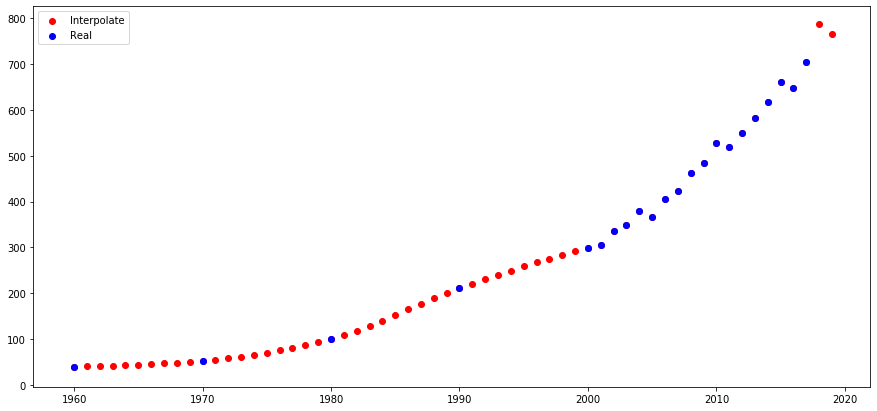

In [99]:
# Try 1 and 11
x = COLI.loc[:,11].astype(float)
y = x.interpolate(method = 'pchip', limit_direction = 'both')

# Plot
plt.figure(figsize=(15,7))
plt.scatter(COLI.index, y, color = 'red', label = 'Interpolate')
plt.scatter(COLI.index, x, color = "blue", label = 'Real')

plt.legend()
plt.show()

### **2.2. Consumer Price Index**

Information about consumer price index (CPI) in the US is available in [IPUMS-CPS](https://cps.ipums.org/cps/). It is always nice to take a look at the raw data before working with it:

In [0]:
CPI.head(5)

,CPI99
YEAR,
1962,5.572
1962,5.572
1962,5.572
1962,5.572
1962,5.572


The reason we see a lot of identical value for the same year is that IPUMS-CPS unit of data is person. However, we only need 1 CPI for each year, we will remove all duplicated and missing values.

In [0]:
CPI = CPI.drop_duplicates(keep='first')
CPI = CPI.dropna()
CPI = CPI.rename(columns = {'CPI99':'PriceIndex'})
CPI.head(5)

,PriceIndex
YEAR,
1962,5.572
1963,5.517
1964,5.444
1965,5.374
1966,5.289


CPI reported by IPUMS-CPS is based on 1999 dollars. We convert it to 2018 dollars.

In [0]:
# Convert price index to 2018 dollar from 1999 dollar
CPI2019 = CPI.loc[2019]
CPI['PriceIndex'] = CPI['PriceIndex'].apply(lambda x: x/CPI2019)
CPI.head(5)

,PriceIndex
YEAR,
1962,8.404223
1963,8.321267
1964,8.211161
1965,8.105581
1966,7.977376


HHINCOME reports the total money income during the **previous calendar** year of all adult household members. The amount should equal the sum of all household members' individual incomes as recorded in the IPUMS-CPS variable INCTOT. The persons included were those present in the household at the time of the survey. People who lived in the household during the previous year but were not still living there at the time of the survey are not included; household members who lived elsewhere during the previous year but had joined the household at the time of the survey are included.

Since HHINCOME in data year is not the total income in that year, but rather in year n - 1, we need to use CPI in year n - 1 as the deflator for HHINCOME in year n. 

In [0]:
# Compute CPI by inverting price index of previous year
CPI["CPI"] = np.nan
# (Not compute the very first CPI because the price index is not available)
for i in range(min(CPI.index)+1, max(CPI.index)+1):
  CPI.loc[i, 'CPI'] = 1/ CPI.loc[i-1, 'PriceIndex']
CPI

,PriceIndex,CPI
YEAR,,
1962,8.404223,NaN
1963,8.321267,0.118988
1964,8.211161,0.120174
1965,8.105581,0.121785
1966,7.977376,0.123372
1967,7.755656,0.125355
1968,7.523379,0.128938
1969,7.220211,0.132919
1970,6.847662,0.138500


A side note is that, similar to COLI, CPI grows linearly (or quandratically?), as shown below. Therefore, it is possible to infer CPI if we ever need to. 

Text(0, 0.5, 'CPI')

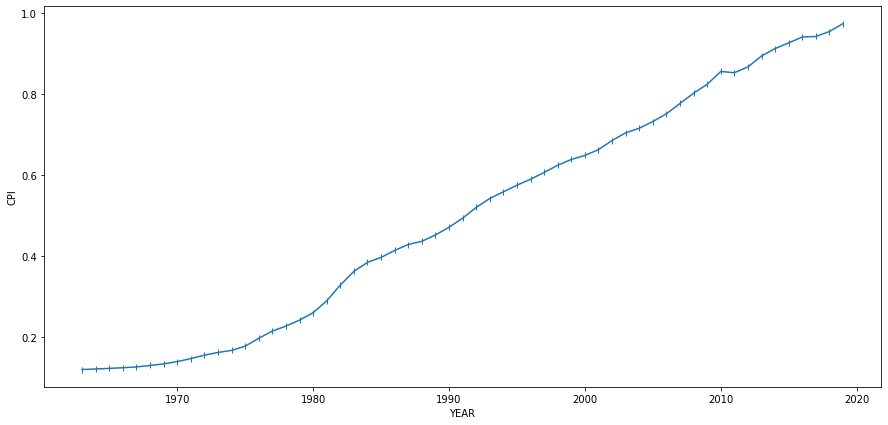

In [0]:
plt.figure(figsize=(15,7))
plt.plot(CPI.index, CPI.CPI, marker = '|')
plt.xlabel("YEAR")
plt.ylabel("CPI")

### **2.3. Household Size**

Since our unit of analysis is household, we initialize a new dataframe (hhsize, or household size) and a new variable (ISIZE, or individual size) to account for the different in household size. For household $j$ in the sample with $n$ members,

$$ HHSIZE_j = \sum_{i = 1}^{n} ISIZE_{n} $$

Each member in the household may have different SIZE. Specifically:
* Household head (PERNUM = 1): ISIZE = 1 unit.
* Adult (PERNUM $\neq$ 1 and AGE > 16): ISIZE = 0.7 unit.
* Child (PERNUM $\neq$ 1 and AGE $\leq$ 16): ISIZE = 0.5 unit.

**Reference:**

"The OECD scale assigns a weight of 1.0 to the first adult, 0.7 to each additional adult, and 0.5 to each child. In the PSID, a child is a family member age 17 or younger. In the CPS and the CEX, we define a child as age 16 or younger. The original OECD definition is age 13 or younger."

Footnote 32, page 27, "Unequal We Stand: An Empirical Analysis of Economic Inequality in the United States, 1967—2006"
Jonathan Heathcote, Fabrizio Perri, and Giovanni L. Violante
https://ideas.repec.org/c/red/ccodes/09-214.html  

In [0]:
# Generate size
raw["ISIZE"] = np.nan

raw.loc[raw["PERNUM"] == 1, "ISIZE"] = 1
raw.loc[(raw["PERNUM"] != 1) & (raw["AGE"] > 16), "ISIZE"] = 0.7
raw.loc[(raw["PERNUM"] != 1) & (raw["AGE"] <= 16), "ISIZE"] = 0.5

raw.head(5)

,YEAR,ASECWTH,CPI99,STATEFIP,HHINCOME,PERNUM,ASECWT,AGE,SEX,RACE,HISPAN,EDUC,INCTOT,INCWAGE,ISIZE
1685415,1977,856.04,2.928,23,11500.0,1,856.04,48,2,100,0.0,110.0,11500,11000,1.0
1685416,1977,856.04,2.928,23,11500.0,2,803.60,15,1,100,0.0,32.0,0,0,0.5
1685417,1977,856.04,2.928,23,44310.0,1,856.04,47,1,100,0.0,122.0,38800,0,1.0
1685418,1977,856.04,2.928,23,44310.0,2,856.04,45,2,100,0.0,72.0,4000,4000,0.7
1685419,1977,856.04,2.928,23,44310.0,3,814.43,19,2,100,0.0,80.0,670,670,0.7


To calculate household size effectively (i.e. to compute household size without having to iterate through nearly 8 millions line of data), we create a new variable called HHID (household ID) by assigning a unique number to each household. With HHID, we can group each household easily. 

In [0]:
# Generate household ID
raw["HHID"] = np.nan
length = sum(raw.loc[raw['PERNUM'] == 1, 'PERNUM'])
raw.loc[raw['PERNUM'] == 1, 'HHID'] = np.arange(length)
raw = raw.fillna(method='pad')

raw.head(5)

,YEAR,ASECWTH,CPI99,STATEFIP,HHINCOME,PERNUM,ASECWT,AGE,SEX,RACE,HISPAN,EDUC,INCTOT,INCWAGE,ISIZE,HHID
1685415,1977,856.04,2.928,23,11500.0,1,856.04,48,2,100,0.0,110.0,11500,11000,1.0,0.0
1685416,1977,856.04,2.928,23,11500.0,2,803.60,15,1,100,0.0,32.0,0,0,0.5,0.0
1685417,1977,856.04,2.928,23,44310.0,1,856.04,47,1,100,0.0,122.0,38800,0,1.0,1.0
1685418,1977,856.04,2.928,23,44310.0,2,856.04,45,2,100,0.0,72.0,4000,4000,0.7,1.0
1685419,1977,856.04,2.928,23,44310.0,3,814.43,19,2,100,0.0,80.0,670,670,0.7,1.0


We then compute the household size for each household ID by taking the sum of all individual sizes in the household. After that, we merge hhsize with the raw dataset and drop PERNUM since we no longer need it. Having the raw dataframe clean, we can merge it with the (flatten) deflator generated in section 2 based on YEAR and STATEFIP.

In [0]:
# Generate effective size
hhsize = raw.groupby(['HHID'])['ISIZE'].agg('sum').reset_index()

# Merge effective size with raw
raw = pd.merge(raw, hhsize, on = ["HHID"])

# Rename 'sizes'
raw = raw.rename(columns={'ISIZE_x': 'ISIZE', 'ISIZE_y': 'HHSIZE'})

# Eliminate observations that has PERNUM != 1
raw = raw[raw.PERNUM == 1]

### **2.4. Household Income Deflating**

Since 3 deflators are now separated in 3 dataframe, we first merge them together with household income before further analysis. First, we multiple COLI and CPI to create COLICPI dataframe.

In [0]:
# Generate COLICPI dataframes
COLICPI = pd.DataFrame(data = COLI, index = year_cps, columns = statefip) 
COLICPI.head(5)

,1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56
1977,0.772318,1.450699,1.090031,0.807407,1.318247,1.072624,1.251662,1.134123,0.999301,1.160598,1.026369,1.258392,0.868806,1.119625,0.960448,0.856802,0.868104,0.782793,0.820953,0.929415,1.163410,1.250166,1.040126,1.060124,0.767847,0.904458,0.809892,0.861678,1.342583,1.180960,1.311818,0.869594,1.102771,0.934105,0.754488,0.972019,0.845718,1.022933,0.937776,1.063760,0.889277,0.800957,0.862542,0.986295,0.967306,0.986234,1.128182,1.081625,0.715479,1.011254,0.825905
1978,0.774430,1.427614,1.087604,0.803354,1.330291,1.080329,1.249518,1.136778,1.041474,1.161810,1.025323,1.286548,0.865994,1.111225,0.951036,0.848143,0.864135,0.780915,0.825813,0.923329,1.181155,1.253199,1.027687,1.050750,0.769874,0.897759,0.807210,0.856850,1.327377,1.179145,1.316427,0.868368,1.114558,0.932910,0.751546,0.960816,0.841710,1.025142,0.936214,1.064169,0.890928,0.793115,0.862377,0.988585,0.970066,0.988642,1.138062,1.088107,0.714276,1.000147,0.827166
1979,0.776288,1.407314,1.085470,0.799789,1.340882,1.087105,1.247633,1.139113,1.078559,1.162876,1.024403,1.311308,0.863522,1.103838,0.942758,0.840528,0.860645,0.779264,0.830088,0.917977,1.196759,1.255867,1.016748,1.042507,0.771656,0.891868,0.804852,0.852605,1.314005,1.177549,1.320481,0.867290,1.124923,0.931859,0.748959,0.950964,0.838186,1.027084,0.934840,1.064528,0.892380,0.786220,0.862233,0.990599,0.972493,0.990760,1.146749,1.093807,0.713218,0.990380,0.828274
1980,0.803144,1.596643,1.117149,0.790414,1.206258,1.074716,1.108662,1.053499,0.968633,1.095932,0.904983,1.329314,0.917713,1.049256,0.917713,0.960146,0.934686,0.837090,0.904983,0.904983,1.117149,1.087446,1.066229,1.015309,0.769197,0.900740,0.854063,0.904983,1.329314,1.074716,1.146852,0.904983,1.057742,0.875280,0.883766,0.960146,0.909226,1.091689,0.960146,0.955903,0.879523,0.807387,0.875280,1.045012,1.002579,0.947416,1.112905,1.074716,0.832847,1.006823,1.074716
1981,0.779403,1.373270,1.081891,0.793811,1.358643,1.098468,1.244471,1.143028,1.140753,1.164664,1.022860,1.352832,0.859376,1.091449,0.928877,0.827757,0.854792,0.776495,0.837255,0.909002,1.222928,1.260340,0.998404,1.028683,0.774644,0.881988,0.800897,0.845485,1.291579,1.174873,1.327279,0.865482,1.142306,0.930097,0.744621,0.934443,0.832276,1.030341,0.932536,1.065131,0.894815,0.774655,0.861990,0.993976,0.976563,0.994311,1.161319,1.103365,0.711443,0.974000,0.830134


For every year $n$  and state $s$: $ COLICPI_{n, s} = COLI_{n, s} \cdot CPI_{n-1}$

In [0]:
# Compute COLICPI
for i in year_cps:
  COLICPI.loc[i] = COLICPI.loc[i] * CPI.loc[i-1, 'CPI']

COLICPI.head(10)

,1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56
1977,0.151538,0.284644,0.213877,0.158423,0.258656,0.210462,0.245591,0.222528,0.196075,0.227723,0.201386,0.246911,0.170470,0.219684,0.188451,0.168115,0.170332,0.153593,0.161081,0.182362,0.228275,0.245297,0.204085,0.208009,0.150661,0.177465,0.158910,0.169071,0.263431,0.231718,0.257394,0.170625,0.216377,0.183282,0.148039,0.190722,0.165940,0.200712,0.184003,0.208722,0.174487,0.157157,0.169241,0.193523,0.189797,0.193511,0.221363,0.212228,0.140386,0.198420,0.162052
1978,0.165789,0.305621,0.232832,0.171980,0.284786,0.231275,0.267495,0.243359,0.222957,0.248718,0.219499,0.275422,0.185390,0.237889,0.203596,0.181569,0.184992,0.167177,0.176789,0.197665,0.252859,0.268283,0.220005,0.224943,0.164813,0.192190,0.172806,0.183433,0.284162,0.252429,0.281818,0.185899,0.238602,0.199716,0.160890,0.205690,0.180192,0.219460,0.200423,0.227815,0.190728,0.169789,0.184616,0.211634,0.207670,0.211647,0.243634,0.232940,0.152911,0.214110,0.177078
1979,0.175778,0.318664,0.245788,0.181100,0.303622,0.246158,0.282507,0.257934,0.244223,0.263315,0.231960,0.296925,0.195531,0.249947,0.213473,0.190324,0.194880,0.176452,0.187960,0.207862,0.270987,0.284371,0.230227,0.236059,0.174729,0.201950,0.182246,0.193059,0.297536,0.266638,0.299002,0.196384,0.254721,0.211005,0.169590,0.215331,0.189794,0.232567,0.211680,0.241046,0.202066,0.178027,0.195239,0.224306,0.220206,0.224342,0.259664,0.247675,0.161497,0.224256,0.187550
1980,0.193701,0.385076,0.269432,0.190631,0.290924,0.259198,0.267386,0.254081,0.233614,0.264315,0.218263,0.320602,0.221333,0.253058,0.221333,0.231567,0.225426,0.201888,0.218263,0.218263,0.269432,0.262269,0.257152,0.244871,0.185514,0.217239,0.205982,0.218263,0.320602,0.259198,0.276596,0.218263,0.255105,0.211099,0.213146,0.231567,0.219286,0.263292,0.231567,0.230543,0.212122,0.194724,0.211099,0.252035,0.241801,0.228497,0.268409,0.259198,0.200865,0.242824,0.259198
1981,0.202248,0.356352,0.280741,0.205987,0.352556,0.285043,0.322929,0.296606,0.296015,0.302220,0.265423,0.351048,0.223001,0.283221,0.241035,0.214796,0.221811,0.201494,0.217260,0.235878,0.317339,0.327047,0.259077,0.266934,0.201013,0.228868,0.207826,0.219396,0.335153,0.304869,0.344417,0.224585,0.296418,0.241352,0.193223,0.242480,0.215968,0.267364,0.241985,0.276392,0.232197,0.201016,0.223679,0.257928,0.253409,0.258015,0.301352,0.286314,0.184613,0.252744,0.215412
1982,0.225542,0.392559,0.312109,0.228592,0.394669,0.318725,0.359127,0.330687,0.337158,0.336677,0.295304,0.395897,0.247757,0.313792,0.266644,0.237568,0.246224,0.223982,0.242751,0.261503,0.356491,0.364645,0.286184,0.295484,0.224152,0.253588,0.230887,0.243381,0.370380,0.339080,0.384268,0.249807,0.332125,0.268479,0.214582,0.267929,0.239712,0.298052,0.269117,0.307778,0.258800,0.222375,0.248990,0.287562,0.282616,0.287680,0.337274,0.319919,0.205311,0.279374,0.240044
1983,0.256384,0.441293,0.353799,0.258706,0.450182,0.363182,0.407218,0.375825,0.390474,0.382358,0.334981,0.454553,0.280689,0.354606,0.300906,0.268042,0.278734,0.253876,0.276424,0.295685,0.407903,0.414438,0.322524,0.333646,0.254790,0.286588,0.261564,0.275348,0.417576,0.384526,0.437001,0.283308,0.379146,0.304507,0.243010,0.302033,0.271336,0.338702,0.305164,0.349408,0.294047,0.250949,0.282577,0.326810,0.321283,0.326966,0.384637,0.364311,0.232809,0.315041,0.272686
1984,0.283210,0.482524,0.389831,0.284631,0.498828,0.402055,0.448810,0.415068,0.438538,0.422007,0.369328,0.506631,0.309110,0.389615,0.330190,0.294078,0.306740,0.279705,0.305825,0.325047,0.453244,0.457732,0.353478,0.366314,0.281436,0.314899,0.288038,0.302846,0.457819,0.423838,0.482913,0.312293,0.420420,0.335683,0.267523,0.331103,0.298572,0.374034,0.336340,0.385511,0.324672,0.275374,0.311682,0.360931,0.354921,0.361125,0.426125,0.403074,0.256591,0.345470,0.301036
1985,0.301145,0.508303,0.413563,0.301550,0.531908,0.428359,0.476249,0.441274,0.473275,0.448385,0.392036,0.543080,0.327769,0.412265,0.348975,0

For convinient reason, we flatten the 2D COLICPI table to a 1D COLICPI series with 2 indices (STATEFIP and YEAR)

In [0]:
# Flatten deflator matrix
fCOLICPI = np.matrix(COLICPI).flatten()
fCOLICPI = pd.DataFrame(fCOLICPI)
fCOLICPI = fCOLICPI.T
fCOLICPI.rename(columns = {0: 'COLICPI'}, inplace = True)

# Index YEAR
year_cps_multiply = np.tile(year_cps,len(statefip))
fCOLICPI['YEAR'] = year_cps_multiply

# Index STATEFIP
statefip_multiply = np.tile(statefip,len(year_cps))
statefip_multiply.sort()
fCOLICPI['STATEFIP'] = statefip_multiply

fCOLICPI.head(10)

,COLICPI,YEAR,STATEFIP
0,0.151538,1977,1
1,0.284644,1978,1
2,0.213877,1979,1
3,0.158423,1980,1
4,0.258656,1981,1
5,0.210462,1982,1
6,0.245591,1983,1
7,0.222528,1984,1
8,0.196075,1985,1
9,0.227723,1986,1


Merging fCOLICPI and raw dataframe:

In [0]:
# Merge raw and flatten deflator on YEAR and STATEFIP
raw = pd.merge(raw, fCOLICPI, on = ["YEAR", "STATEFIP"])
raw.head(5)

,YEAR,ASECWTH,CPI99,STATEFIP,HHINCOME,PERNUM,ASECWT,AGE,SEX,RACE,HISPAN,EDUC,INCTOT,INCWAGE,ISIZE,HHID,HHSIZE,COLICPI
0,1977,856.04,2.928,23,11500.0,1,856.04,48,2,100,0.0,110.0,11500,11000,1.0,0.0,1.5,0.656513
1,1977,856.04,2.928,23,44310.0,1,856.04,47,1,100,0.0,122.0,38800,0,1.0,1.0,3.4,0.656513
2,1977,801.57,2.928,23,23314.0,1,801.57,63,1,100,902.0,72.0,18724,12000,1.0,2.0,1.7,0.656513
3,1977,657.13,2.928,23,8805.0,1,657.13,29,2,100,0.0,121.0,8805,4000,1.0,3.0,1.5,0.656513
4,1977,632.23,2.928,23,13424.0,1,632.23,29,1,100,0.0,90.0,6724,5300,1.0,4.0,2.7,0.656513


Now we have all deflators together with household income, we can deflate household income. 

In [0]:
# Generate deflated household income column
raw["DHHINCOME"] = np.nan
raw.DHHINCOME = raw.HHINCOME/(raw.COLICPI*raw.HHSIZE)
raw.head(5)

,YEAR,ASECWTH,CPI99,STATEFIP,HHINCOME,PERNUM,ASECWT,AGE,SEX,RACE,HISPAN,EDUC,INCTOT,INCWAGE,ISIZE,HHID,HHSIZE,COLICPI,DHHINCOME
0,1977,856.04,2.928,23,11500.0,1,856.04,48,2,100,0.0,110.0,11500,11000,1.0,0.0,1.5,0.656513,11677.860335
1,1977,856.04,2.928,23,44310.0,1,856.04,47,1,100,0.0,122.0,38800,0,1.0,1.0,3.4,0.656513,19850.869237
2,1977,801.57,2.928,23,23314.0,1,801.57,63,1,100,902.0,72.0,18724,12000,1.0,2.0,1.7,0.656513,20889.332674
3,1977,657.13,2.928,23,8805.0,1,657.13,29,2,100,0.0,121.0,8805,4000,1.0,3.0,1.5,0.656513,8941.179152
4,1977,632.23,2.928,23,13424.0,1,632.23,29,1,100,0.0,90.0,6724,5300,1.0,4.0,2.7,0.656513,7573.120635


## **Section 3. Data processor**

### **3.1 Preparation**

First of all, we import some important components for rendering our final graph later in JavaScript format. We also generate decile and percentile lists. The reason why for percentile we start from 2p instead of 1p is for 1p, deflated household income is negative (or maybe I should eliminate negative household income before runing the analysis? What do you think?)

In [0]:
# Create decile and percentile arrays
decile = np.arange(0.05, 1.05, 0.1)
decile = np.insert(arr = decile, obj = 5, values = 0.5)
percentile = np.arange(0.02, 1, 0.01)

# Create decile and percentile name
decileName = ['5p', '15p', '25p', '35p', '45p', '50p', '55p', '65p', '75p', '85p', '95p']
percentileName = ['2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p', '11p',
                  '12p', '13p', '14p', '15p', '16p', '17p', '18p', '19p', '20p',
                  '21p', '22p', '23p', '24p', '25p', '26p', '27p', '28p', '29p',
                  '30p', '31p', '32p', '33p', '34p', '35p', '36p', '37p', '38p',
                  '39p', '40p', '41p', '42p', '43p', '44p', '45p', '46p', '47p',
                  '48p', '49p', '50p', '51p', '52p', '53p', '54p', '55p', '56p',
                  '57p', '58p', '59p', '60p', '61p', '62p', '63p', '64p', '65p',
                  '66p', '67p', '68p', '69p', '70p', '71p', '72p', '73p', '74p',
                  '75p', '76p', '77p', '78p', '79p', '80p', '81p', '82p', '83p',
                  '84p', '85p', '86p', '87p', '88p', '89p', '90p', '91p', '92p',
                  '93p', '94p', '95p', '96p', '97p', '98p', '99p']

# Open HLTM environment
html1_d_1year = open(in_path + 'html1_d_1year.txt', 'r')
html1_p_1year = open(in_path + 'html1_p_1year.txt', 'r')
html2 = open(in_path + 'html2.txt', 'r')

Since we do not want the final graph to have all states being labeled, we select a few states that we are interested in to put label on. 

In [0]:
# Labels that will appear in the final graph
label_list = ['California', 'District of Columbia', 'Indiana', 'New York']

We create ```state_name``` and ```state_label``` dataframe.

In [0]:
# Create state_Name and state_label dataframes
notLabelList = list(set(state_name) - set(label_list))
notLabelDict = dict.fromkeys(notLabelList , '')
state_name = pd.DataFrame(data = state_name, index = statefip, columns = ['State'])
state_label = state_name.replace(to_replace = notLabelDict)
state_label = state_label.rename(columns={'State': 'Label'})

We create CUMWTH (cummulated household weight) and PERCENT (percentile for each household) as a way to rank income of each household

In [0]:
# Generate cumulative weight and percentage
raw["CUMWTH"] = np.nan
raw["PERCENTH"] = np.nan

### **3.2 Generate k-ile graphs**

There is idea about stacked area chart for one state graph

First, we need to choose if we want to generate decile or percentile graph. Second, we need to decide if we want one year per graph or one state per graph. 

In [0]:
# Choose k: decile (11) or percentile (98)
k = 11

In [0]:
if (k == 11):
  k_ile = decile
  kName = decileName

if (k == 98):
  k_ile = percentile
  kName = percentileName

The chunk of code below must run together as a whole to render all graphs in range from 1978 to 2018. It's a long chunk of code, which may be hard to understand. For the purpose of demostration and explanation, we dedicated a portion below to illustrate the mechanism behind the analysis. We do so by breaking the very first for loop, leading to the fact that we can only render 1 graph for 1 state at a time. 

For this example, we will only work with YEAR = 1978

In [0]:
  # Generate year dataframe
  year = raw[raw.YEAR == 1977]
  y = 1977

After that, we generate a result grid, which have the k-iles for each state at a year. 

In [0]:
  # Generate result grid, decile-column
  result = pd.DataFrame(data = None, index = kName, columns = statefip)
  result.head(5)

,1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56
5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For every state, we sort the deflated household income ascendingly. We then calculate the household cumulated weight (CUMWTH) and the household percentile (PERCENTH). For household $j$th in the DHHINCOME-sorted dataframe with $k$ households:

$$CUMWTH_j = \sum_{i=0}^{j} ASECWTH_i $$

$$PERCENTH_j = \frac{CUMWTH_j}{\sum_{i=0}^{k} ASECWTH_i}$$

To calculate DHHINCOME at each k_ile $k$ for state $s$, we select a series of DHHINCOME that has percentile under or equal to $k$ (set S):
$$S_k = \{DHHINCOME_s | PERCENTH_s \leq k \} $$

DHHINCOME at k_ile $k$ for state s is the maximum value of set $S$: 

$$ DHHINCOME_{k, s} = max(S_k) $$

In [0]:
  # Iterate through each state
  c = 0
  for i in statefip:
    # Generate state dataframe
    state = year[year.STATEFIP == i]
    state = state.reset_index(drop = True)

    # Sort state dataframe by DHHINCOME
    state = state.sort_values('DHHINCOME')
    
    # Calculate cumulated weight and Percentage
    state.CUMWTH = state.ASECWTH.cumsum()
    state.PERCENTH = state.CUMWTH/(state.ASECWTH.sum())
    
    # Calculate decile
    r = 0
    for k in k_ile:
      result.iloc[r,c] = state.loc[state['PERCENTH'] <= k, 'DHHINCOME'].max()
      r = r + 1
    c = c + 1

The result table is presented as below:

In [0]:
  result

,1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56
5p,6062.28,9783.2,4825.23,5285.47,8217.39,4197.47,7795.55,5173.83,4042.42,2846.85,2734.6,4884.15,3026.95,4103.38,5297.24,3787.78,3190.03,4259.81,1407.53,2240.63,2846.33,4333.89,2659.6,2343.85,1729.88,1645.12,1871.13,2626.58,3417.88,2438.62,3763.49,1275.36,3054.64,1994.18,2710.97,2852.55,2150.3,2053.52,1850.06,2286.28,1099.59,900.137,1073.8,1375.65,1683.59,2300.89,2063.58,1279.78,2034.63,2343.26,1081.83
15p,13392.1,20229.6,11653.8,10121.3,13845.7,7845.34,13032,8466.45,7396.04,4833.17,5408.15,10500.5,5279.26,7713.66,8623.29,6846.37,6971.98,6472.22,3241.22,3503.36,6298.98,6655.29,4330.11,3952.93,3781.64,2885.5,3833.14,4489.1,5747.41,4259.43,6287.08,2547.67,4979.95,3487.79,5334.37,5221.05,3613.13,3490.47,3161.86,3416.4,2383.05,2216.99,1872.91,2628.65,2645.57,3942.39,3376.74,2270.57,3520.54,4129.21,2141.72
25p,17863.9,26706.1,17002.7,12659.3,17451.5,10740.2,17578,10749.3,11027.8,6593.32,7785.87,14100.2,6671.42,10772,11809,9460.7,9397.86,8606.01,3964.18,4667.24,8509.24,9110.71,5914.57,5223.23,4651.21,3899.36,5428.65,5679.29,7942.97,5615.89,8339.73,3639.39,6436.56,4903.96,7028.25,6987.8,4880.19,4800.11,4187.49,4278.6,3346.26,2892.94,2423.76,3771.28,3358.56,4912.63,4640.55,2953.21,4607.68,5198.29,2964.22
35p,24053.4,35482.5,22448.9,15405.2,22417.7,13246.1,21615.7,14585.8,16384.7,8307.22,10028.7,16819.2,8694.62,13831.5,15100.2,11607.9,11702.6,10699.9,5312.53,6203.9,10840.7,11722.8,7660.7,6353.67,5980.13,4971.58,6349.49,6905.24,9666.91,6927.84,10306,4722.62,8242.08,6460.67,8660.06,8527.94,6165.75,5964.26,5072.08,5474.11,4329.08,3666.02,3183.94,4885.66,4164.18,6263.37,5844.56,3750.33,5777.36,6520.86,3489.68
45p,29761.5,44768,27665.2,18977.6,27678.5,16393.8,25700.8,16918,21295.7,10184.3,12768.4,20198.7,10035.9,16628.1,17480,14306.1,13911.9,13306,6859.07,7529.08,13337.9,13895.8,9142.38,7565.71,7395.79,6250.69,7740.16,8208.55,11608.6,8106.68,12309.1,5907.77,10107.6,7700.6,10631.1,9954.71,7651.5,7111.51,6182.18,6267.56,5957.25,4486.4,4026.75,6047.15,4958.84,7458.57,7293.33,4776.58,6977.07,7628.07,4145.87
50p,32769.9,48994.1,29656.3,21066.3,30748.9,17935.7,27122.6,19272.1,22938.5,11267.5,14124.1,21416.4,10789,18290.9,18975.1,15625.7,15194,14445.8,7734.13,7896.07,14571.7,15002.8,10001.3,8209.4,8110.66,6811.04,8432.82,8678.97,12744.8,8964.68,13525.1,6592.36,11092.4,8525.12,11854.2,10697.1,8419.44,7794.69,6734.87,6947.28,6481.6,4909.51,4544.55,6773.08,5461.35,7999.92,8022.46,5321.1,7521.15,8332.45,4500.48
55p,35634.6,53439.5,32275.9,23479.9,33322,19581.6,30045.5,20809.9,25730,12388,15886.3,23057.5,11832.1,19840.3,20275.2,16794.6,16490.5,15456.4,8862.47,8582.2,15759,16539.1,10792.2,8959.97,9178.87,7533.38,9218.91,9303.66,13865.7,9411.01,14707.7,7371.91,12180.6,9214.18,13398.3,11615.5,9177.97,8487.85,7244.74,7576.63,6945.59,5478.03,4922.44,7485.18,5994.17,8588.77,8684.73,5823.77,8090.2,8907,4818.01
65p,44353.1,64447.7,36648.6,27565.9,39768.6,23314.6,35247.3,24353,31403.9,14860.8,19013.9,26443,14365.1,23128.1,23926.2,19371.2,19572.2,18119.9,11292.3,9978.38,18230.1,18692.5,12578.7,10690.3,11772.8,9039.97,10713.5,11186.4,16483.8,11346.3,17274.8,8820.66,14615.6,10737.9,16218,13919.3,11035,9850.87,8430.87,9066.21,8366.55,6593.95,6085.85,9004.33,7188.36,10256.3,10292.8,6956.23,9835.75,10373.4,5448.76
75p,54716.7,77957.1,44197.2,34698.3,48246.7,27876.2,41944.8,29003.1,36424.1,17738,23038.3,30610.1,17323.1,27601.5,28077.2,23741.4,23400.7,22058.1,13748.5,11827.2,20979.7,22433.7,14875.3,12722.1,14266,10963.2,12764.8,13148.7,19444.9,13576.6,20597.9,10643.7,17703,13160,19156.9,16564.6,13536.5,11789,9911.8,10805.3,9958.86,8016.48,7309.3,10804.6,8710.04,12737.1,11973.2,8447.2,11832.9,12064.3,6483.64
85p,69188.6,99811.9,53215.7,44567.1,60477.6,33513.1,51815.2,35040.3,49154,21973.3,28430.1,38444.5,21237.5,34263.9,35500.3,28808.3,29712.6,26564.6,17200.9,14700.6,26107.6,26121.5,18694.8,15587.1,17734.7,13572.4,15969.8,158

We transpose the result dataframe so that we can merge them with codeFirst_oneYear and codeThird_oneYear

In [0]:
  # Transpose result table: column-decile
  result = result.T
  result.head(10)

,5p,15p,25p,35p,45p,50p,55p,65p,75p,85p,95p
1,6062.28,13392.1,17863.9,24053.4,29761.5,32769.9,35634.6,44353.1,54716.7,69188.6,93950.4
2,9783.2,20229.6,26706.1,35482.5,44768,48994.1,53439.5,64447.7,77957.1,99811.9,149610
4,4825.23,11653.8,17002.7,22448.9,27665.2,29656.3,32275.9,36648.6,44197.2,53215.7,84507.7
5,5285.47,10121.3,12659.3,15405.2,18977.6,21066.3,23479.9,27565.9,34698.3,44567.1,71480.7
6,8217.39,13845.7,17451.5,22417.7,27678.5,30748.9,33322,39768.6,48246.7,60477.6,88737.2
8,4197.47,7845.34,10740.2,13246.1,16393.8,17935.7,19581.6,23314.6,27876.2,33513.1,45544.3
9,7795.55,13032,17578,21615.7,25700.8,27122.6,30045.5,35247.3,41944.8,51815.2,70765.7
10,5173.83,8466.45,10749.3,14585.8,16918,19272.1,20809.9,24353,29003.1,35040.3,48329.6
11,4042.42,7396.04,11027.8,16384.7,21295.7,22938.5,25730,31403.9,36424.1,49154,81802.1
12,2846.85,4833.17,6593.32,8307.22,10184.3,11267.5,12388,14860.8,17738,21973.3,32888.6


We sort the result by median (50p) and concatenate it with ```state_name```, ```state_label```, and ```colors```. 

In [0]:
  # Sort the result by median
  result = result.sort_values(by = ['50p'], ascending = True)
  colors1977 = pd.DataFrame(data = list(colors.Color), index = result.index, columns=['Color'])
  result = pd.concat([state_name, result, state_label, colors1977], axis = 1)
  result.head(5)

,State,5p,15p,25p,35p,45p,50p,55p,65p,75p,85p,95p,Label,Color
1,Alabama,6062.28,13392.1,17863.9,24053.4,29761.5,32769.9,35634.6,44353.1,54716.7,69188.6,93950.4,,#0AFF00
2,Alaska,9783.2,20229.6,26706.1,35482.5,44768,48994.1,53439.5,64447.7,77957.1,99811.9,149610,,#00FF00
4,Arizona,4825.23,11653.8,17002.7,22448.9,27665.2,29656.3,32275.9,36648.6,44197.2,53215.7,84507.7,,#1EFF00
5,Arkansas,5285.47,10121.3,12659.3,15405.2,18977.6,21066.3,23479.9,27565.9,34698.3,44567.1,71480.7,,#47FF00
6,California,8217.39,13845.7,17451.5,22417.7,27678.5,30748.9,33322,39768.6,48246.7,60477.6,88737.2,California,#14FF00


We compute the population (POP) and normalized population for each state in a new dataframe (pop). For state $s$ that has $k$ households in year $y$:

$$POP_s = \sum_{i=0}^{k} ASECWTH_i$$

$$NORMPOP_s = \frac{POP_s}{min(POP_s)}$$ 

In [0]:
  # Compute state population and normalized state population
  pop = pd.DataFrame(index = statefip)
  pop["POP"] = np.nan
  pop.POP = year.groupby(['STATEFIP'])['ASECWT'].agg('sum')

  pop["NORMPOP"] = np.nan
  pop.NORMPOP = round(pop.POP/(pop.POP.min()))

  pop

,POP,NORMPOP
1,1301713.96,11.0
2,116622.28,1.0
4,789233.03,7.0
5,687999.56,6.0
6,7934076.94,68.0
8,1046900.30,9.0
9,1078354.27,9.0
10,188215.87,2.0
11,252873.12,2.0
12,3079626.13,26.0


In [0]:
  # Replicate each state's dataline with its respected replication number
  for i in statefip:
    rep = pop.loc[i,'NORMPOP'] - 1
    rep = int(rep)
    line = pd.DataFrame(result.loc[i]).T
    line.loc[i, 'Label'] = ''
    for i in range(0,rep): result = pd.concat([result, line])
  result.head(10)

,State,5p,15p,25p,35p,45p,50p,55p,65p,75p,85p,95p,Label,Color
1,Alabama,6062.28,13392.1,17863.9,24053.4,29761.5,32769.9,35634.6,44353.1,54716.7,69188.6,93950.4,,#0AFF00
2,Alaska,9783.2,20229.6,26706.1,35482.5,44768,48994.1,53439.5,64447.7,77957.1,99811.9,149610,,#00FF00
4,Arizona,4825.23,11653.8,17002.7,22448.9,27665.2,29656.3,32275.9,36648.6,44197.2,53215.7,84507.7,,#1EFF00
5,Arkansas,5285.47,10121.3,12659.3,15405.2,18977.6,21066.3,23479.9,27565.9,34698.3,44567.1,71480.7,,#47FF00
6,California,8217.39,13845.7,17451.5,22417.7,27678.5,30748.9,33322,39768.6,48246.7,60477.6,88737.2,California,#14FF00
8,Colorado,4197.47,7845.34,10740.2,13246.1,16393.8,17935.7,19581.6,23314.6,27876.2,33513.1,45544.3,,#70FF00
9,Connecticut,7795.55,13032,17578,21615.7,25700.8,27122.6,30045.5,35247.3,41944.8,51815.2,70765.7,,#28FF00
10,Delaware,5173.83,8466.45,10749.3,14585.8,16918,19272.1,20809.9,24353,29003.1,35040.3,48329.6,,#51FF00
11,District of Columbia,4042.42,7396.04,11027.8,16384.7,21295.7,22938.5,25730,31403.9,36424.1,49154,81802.1,District of Columbia,#32FF00
12,Florida,2846.85,4833.17,6593.32,8307.22,10184.3,11267.5,12388,14860.8,17738,21973.3,32888.6,,#D6FF00


Sort the result dataframe by the median. 

In [0]:
  # Sort the result by median
  result = result.sort_values(by = ['50p'], ascending = True)
  result

,State,5p,15p,25p,35p,45p,50p,55p,65p,75p,85p,95p,Label,Color
56,Wyoming,1081.83,2141.72,2964.22,3489.68,4145.87,4500.48,4818.01,5448.76,6483.64,8289.85,11132.1,,#FF0000
47,Tennessee,1073.8,1872.91,2423.76,3183.94,4026.75,4544.55,4922.44,6085.85,7309.3,9318.65,13578.6,,#FF0A00
47,Tennessee,1073.8,1872.91,2423.76,3183.94,4026.75,4544.55,4922.44,6085.85,7309.3,9318.65,13578.6,,#FF0A00
47,Tennessee,1073.8,1872.91,2423.76,3183.94,4026.75,4544.55,4922.44,6085.85,7309.3,9318.65,13578.6,,#FF0A00
47,Tennessee,1073.8,1872.91,2423.76,3183.94,4026.75,4544.55,4922.44,6085.85,7309.3,9318.65,13578.6,,#FF0A00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Alabama,6062.28,13392.1,17863.9,24053.4,29761.5,32769.9,35634.6,44353.1,54716.7,69188.6,93950.4,,#0AFF00
1,Alabama,6062.28,13392.1,17863.9,24053.4,29761.5,32769.9,35634.6,44353.1,54716.7,69188.6,93950.4,,#0AFF00
1,Alabama,6062.28,13392.1,17863.9,24053.4,29761.5,32769.9,35634.6,44353.1,54716.7,69188.6,93950.4,,#0AFF00
1,Alabama,6062.28,13392.1,17863.9,24053.4,29761.5,32769.9,35634.6,44353.1,54716.7,69188.6,93950.4,,#0AFF00


We convert the result dataframe to JSON format.

In [0]:
  # Convert dataframe to JSON
  result = result.to_json(orient = 'records')
  result = json.loads(result, object_pairs_hook = OrderedDict)

  # Make JSON format readable
  result = json.dumps(result, indent = 4, sort_keys = False)

Finally, we render the graph by insert result (JSON format) in our HTML environment. 

In [0]:
  # Insert result to HTML environment
  with open(out_path + 'year_d/' + str(y) + '_d.html', 'w') as outfile:
    outfile.write(html1.read())
    outfile.write(result)
    outfile.write(html2.read())

After the demonstration for YEAR = 1977, we now render for the rest of the year. 

In [0]:
for y in range(1978, 2020):
  # Generate result grid, decile-column
  result = pd.DataFrame(data = None, index = kName, columns = statefip)

  # Generate year dataframe
  year = raw[raw.YEAR == y]

  # Iterate through each state
  c = 0
  for i in statefip:
    # Generate state dataframe
    state = year[year.STATEFIP == i]
    state = state.reset_index(drop = True)

    # Sort state dataframe by DHHINCOME
    state = state.sort_values('DHHINCOME')
    
    # Calculate cumulated weight and Percentage
    state.CUMWTH = state.ASECWTH.cumsum()
    state.PERCENTH = state.CUMWTH/(state.ASECWTH.sum())
    
    # Calculate decile
    r = 0
    for k in k_ile:
      result.iloc[r,c] = state.loc[state['PERCENTH'] <= k, 'DHHINCOME'].max()
      r = r + 1
    c = c + 1

  # Transpose result table: column-decile
  result = result.T
  result.head(10)

  # Sort the result by median
  result = result.sort_values(by = ['50p'], ascending = True)
  result = pd.concat([state_name, result, state_label, colors1977], axis = 1)
  result.head(5)

  # Compute state population and normalized state population
  pop = pd.DataFrame(index = statefip)
  pop["POP"] = np.nan
  pop.POP = year.groupby(['STATEFIP'])['ASECWT'].agg('sum')

  pop["NORMPOP"] = np.nan
  pop.NORMPOP = round(pop.POP/(pop.POP.min()))

  # Replicate each state's dataline with its respected replication number
  for i in statefip:
    rep = pop.loc[i,'NORMPOP'] - 1
    rep = int(rep)
    line = pd.DataFrame(result.loc[i]).T
    line.loc[i, 'Label'] = ''
    for i in range(0,rep): result = pd.concat([result, line])
  result.head(10)

  # Sort the result by median
  result = result.sort_values(by = ['50p'], ascending = True)
  result

  # Convert dataframe to JSON
  result = result.to_json(orient = 'records')
  result = json.loads(result, object_pairs_hook = OrderedDict)

  # Make JSON format readable
  result = json.dumps(result, indent = 4, sort_keys = False)

  # Insert result to HTML environment
  if k == 11:
    html1 = open(in_path + 'html1_d_1year.txt', 'r')
  if k == 99:
    html1 = open(in_path + 'html1_p_1year.txt', 'r')
  html2 = open(in_path + 'html2.txt', 'r')

  with open(out_path + 'year_d/' + str(y) + '_d.html', 'w') as outfile:
    outfile.write(html1.read())
    outfile.write(result)
    outfile.write(html2.read())

### **3.3 Subpopulation**

We can look at the sub-population by modifying the raw dataframe.

In [0]:
raw.head(2)

,YEAR,ASECWTH,CPI99,STATEFIP,HHINCOME,PERNUM,ASECWT,AGE,SEX,RACE,HISPAN,EDUC,INCTOT,INCWAGE,ISIZE,HHID,HHSIZE,COLICPI,DHHINCOME,CUMWTH,PERCENTH
0,1977,856.04,2.928,23,11500.0,1,856.04,48,2,100,0.0,110.0,11500,11000,1.0,0.0,1.5,0.656513,11677.860335,NaN,NaN
1,1977,856.04,2.928,23,44310.0,1,856.04,47,1,100,0.0,122.0,38800,0,1.0,1.0,3.4,0.656513,19850.869237,NaN,NaN


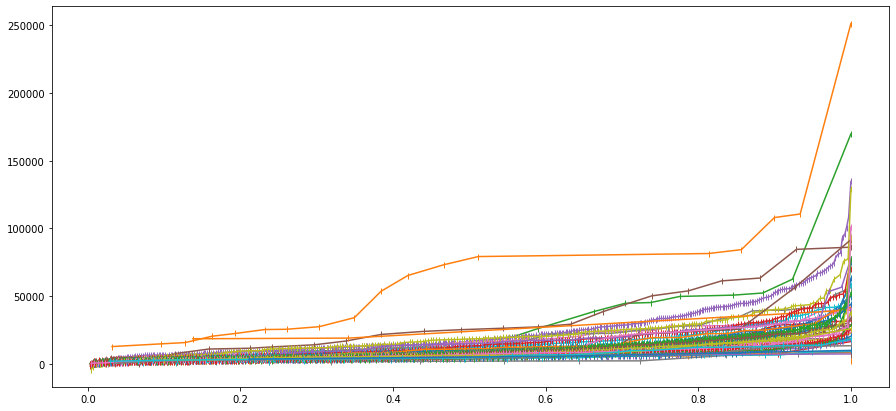

In [0]:
  # Modify raw dataframe
  # Black
  raw_x = raw[raw.RACE == 200]
  # White
  # raw_x = raw[raw.RACE == 200]
  # Asian
  # raw_x = raw[raw.RACE == 200]
  # Hispan
  # raw_x = raw[raw.RACE == 200]
  # Male 
  # raw_x = raw[raw.RACE == 200]
  # Female
  # raw_x = raw[raw.RACE == 200]
  # BA 
  # raw_x = raw[raw.RACE == 200]
  # NonBA
  # raw_x = raw[raw.RACE == 200]

  # Generate year dataframe
  year = raw_x[raw_x.YEAR == 1977]

  # Geneate graph frame
  plt.figure(figsize = (15,7))
  # Iterate through each state
  c = 0
  for i in statefip:
    # Generate state dataframe
    state = year[year.STATEFIP == i]
    state = state.reset_index(drop = True)

    # Sort state dataframe by DHHINCOME
    state = state.sort_values('DHHINCOME')
    
    # Calculate cumulated weight and Percentage
    state.CUMWTH = state.ASECWTH.cumsum()
    state.PERCENTH = state.CUMWTH/(state.ASECWTH.sum())

    plt.plot(state['PERCENTH'], state['DHHINCOME'], marker = '|')
    # if(i == 5): break

### **3.1 Generate k-ile graphs for each year _ 2**

There are 4 differences between d_files and p_files:

*   Deciles
*   Loop to construct result grid sheet (0 to 98 instead of 0 to 11)
*   Use first_p instead of first_d (look at pCodeGenerator excel file for detail about p_code generator)
*   different out_path
*   Change name when export data

In [0]:
import pandas as pd
import json
from collections import OrderedDict
from google.colab import drive
drive.mount('/content/gdrive')
in_path = 'gdrive/My Drive/Colab Notebooks/code/'
out_path = 'gdrive/My Drive/Colab Notebooks/oneYear/year_p/'

# Import raw data state codes, color codes, and deflator
raw = pd.read_csv(in_path + "raw.csv")
codeFirst_oneYear = pd.read_csv(in_path + "codeFirst_oneYear.csv", index_col = 0)
codeThird_oneYear = pd.read_csv(in_path + "codeThird_oneYear.csv", index_col = 0)
deflator = pd.read_csv(in_path + "COLI.csv")

# Generate constants
stateList = [1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,
             28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,
             50,51,53,54,55,56]
decile = [0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,
          0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,
          0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,
          0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,
          0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,
          0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,
          0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
value = ['','','','','','','','','','','','','','','','','','','','','','',
         '','','','','','','','','','','','','','','','','','','','','','',
         '','','','','','','']

# Iterate through each year
for y in range(1978, 1979):
  
  # Generate result grid, decile-column
  result = pd.DataFrame(columns = stateList)
  for i in range(0, 98): result.loc[i] = value
  
  # Generate year dataframe
  year = raw[raw.YEAR == y]
  
  # Eliminate observations that has PERNUM != 1
  person = year[year.PERNUM == 1]
  
  # Merge 2 file: for raw, every row that has STATEFIP and YEAR match with 
  # that row in deflator will get the same deflator value.
  person = pd.merge(person, deflator, on = ["YEAR","STATEFIP"])
  
  # Rearrange culumns order
  person = person[['YEAR', 'ASECWTH', 'STATEFIP', 'HHINCOME', 'PERNUM', 
                   'ASECWT','DEFLATOR','SEX','RACE','HISPAN','EDUC']]
  
  # Generate deflated household income column
  person.insert(7, 'DHHINCOME', '')
  
  # Iterate through the entire 'person' to calculate deflated income
  for i in range (0, len(person)):
    person.iloc[i, 7] = person.iloc[i, 3]/person.iloc[i, 6]
  
  # Sort the remainded observation by STATEFIP
  person.sort_values('STATEFIP')
  
  # Iterate through each state
  c = 0
  for i in stateList:
    # Generate state dataframe
    state = person[person.STATEFIP == i]
    
    # Sort state dataframe by HHINCOME
    state = state.sort_values('HHINCOME')
    
    # Calculate cumulated weight and Percentage
    state.insert(8, 'CUMWT', '')
    state.insert(9, 'PERCENT', '')
    state.iloc[0, 8] = state.iloc[0, 1]
    state.iloc[0, 9] = state.iloc[0, 8]/(state.sum().ASECWT)
    for i in range (1, len(state)):
      state.iloc[i, 8] = state.iloc[i-1, 8] + state.iloc[i, 1]
      state.iloc[i, 9] = state.iloc[i, 8]/(state.sum().ASECWT)
    
    # Calculate decile
    r = 0
    for d in decile:
      for i in range (0, len(state)):
        if (d < state.iloc[i, 9]):
          result.iloc[r,c] = state.iloc[i, 7]
          r = r + 1
          break
    c = c + 1
    
  # Transpose result table: column-decile
  result = result.transpose()

  # Type casting result.index (type casting STATEFIP) to integer
  result.index = result.index.map(int)

  # Merge state dataframe with code dataframe
  result = pd.merge(codeFirst_oneYear, result, left_index = True, right_index = True)
  result = pd.merge(result, codeThird_oneYear, left_index = True, right_index = True)

  result.insert(101, 'POP','')
  r = 0
  for i in stateList:
    state = year[year.STATEFIP == i]
    result.iloc[r, 101] = state.sum().ASECWT
    r = r + 1

  result.insert(102, 'NORMPOP', '')
  for i in range(0, len(result)):
    result.iloc[i, 102] = round(result.iloc[i, 101]/(result['POP'].min()))

  for i in stateList:
    rep = result.loc[int(i),'NORMPOP'] - 1
    rep = int(rep)
    # The following statement need .copy() at the end for explicit reason
    # More information: https://www.dataquest.io/blog/settingwithcopywarning/
    line = result[result.index == i].copy()
    line.name = i
    line.iloc[0, 99] = ''
    for i in range(0,rep): result = result.append(line)
        
  # result.to_csv(out_path+str(y)+'withPop.csv')
  result = result.drop(columns = ['POP', 'NORMPOP'])
      
  # Sort the result by median
  result = result.sort_values(48, ascending = True)

  # Rename index column and role
  result = result.rename(index = str, columns = {0: "2p", 1: "3p", 2: "4p", 3: "5p",
                                                 4: "6p", 5: "7p", 6: "8p", 7: "9p",
                                                 8: "10p", 9: "11p", 10: "12p",
                                                 11: "13p", 12: "14p", 13: "15p",
                                                 14: "16p", 15: "17p", 16: "18p",
                                                 17: "19p", 18: "20p", 19: "21p",
                                                 20: "22p", 21: "23p", 22: "24p",
                                                 23: "25p", 24: "26p", 25: "27p",
                                                 26: "28p", 27: "29p", 28: "30p",
                                                 29: "31p", 30: "32p", 31: "33p",
                                                 32: "34p", 33: "35p", 34: "36p",
                                                 35: "37p", 36: "38p", 37: "39p",
                                                 38: "40p", 39: "41p", 40: "42p",
                                                 41: "43p", 42: "44p", 43: "45p",
                                                 44: "46p", 45: "47p", 46: "48p",
                                                 47: "49p", 48: "50p", 49: "51p",
                                                 50: "52p", 51: "53p", 52: "54p",
                                                 53: "55p", 54: "56p", 55: "57p",
                                                 56: "58p", 57: "59p", 58: "60p",
                                                 59: "61p", 60: "62p", 61: "63p",
                                                 62: "64p", 63: "65p", 64: "66p",
                                                 65: "67p", 66: "68p", 67: "69p",
                                                 68: "70p", 69: "71p", 70: "72p",
                                                 71: "73p", 72: "74p", 73: "75p",
                                                 74: "76p", 75: "77p", 76: "78p",
                                                 77: "79p", 78: "80p", 79: "81p",
                                                 80: "82p", 81: "83p", 82: "84p",
                                                 83: "85p", 84: "86p", 85: "87p",
                                                 86: "88p", 87: "89p", 88: "90p",
                                                 89: "91p", 90: "92p", 91: "93p",
                                                 92: "94p", 93: "95p", 94: "96p",
                                                 95: "97p", 96: "98p", 97: "99p"})
  
  result.to_csv(out_path+str(y) + '_p.csv')

  # Convert dataframe to JSON
  result = result.to_json(orient = 'records')
  result = json.loads(result, object_pairs_hook = OrderedDict)

  # Make JSON format readable
  result = json.dumps(result, indent = 4, sort_keys = False)

  # Save JSON to text format
  with open(out_path + str(y) + '_p.txt', 'w') as f:
    f.writelines(result)

  # Glue data with html environment
  filenames = [in_path + 'first_p_oneYear.txt', out_path + str(y) + '_p.txt',
               in_path + 'third.txt']
  with open(out_path + str(y) + '_p.html', 'w') as outfile:
    for i in filenames:
      with open (i) as infile:
        outfile.write(infile.read())

### **3.2 Generate k-ile graphs for each state**

In [0]:
import pandas as pd
import json
from collections import OrderedDict
from google.colab import drive
drive.mount('/content/gdrive')
in_path = 'gdrive/My Drive/Colab Notebooks/code/'
out_path = 'gdrive/My Drive/Colab Notebooks/oneState/state_d/'

# Import raw data state codes, color codes, and deflator
raw = pd.read_csv(in_path + "raw.csv")
codeFirst_oneState = pd.read_csv(in_path + "codeFirst_oneState.csv", index_col = 0)
codeThird_oneState = pd.read_csv(in_path + "codeThird_oneState.csv", index_col = 0)
deflator = pd.read_csv(in_path +"COLI.csv")

# Select data with HFLAG != 1 and then drop HFLAG
raw = raw[raw.HFLAG != 1]
raw = raw.drop(columns = ['HFLAG'])

# Generate constants
stateList = [1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,
             28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,
             50,51,53,54,55,56]

# stateList = [12]

decile = [0.05,0.15,0.25,0.35,0.45,0.50,0.55,0.65,0.75,0.85,0.95]
value = ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
         '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
         '', '', '', '', '']
yearList = [1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
            1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
            2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

# Iterate through each state
for s in stateList:
  
  # Generate result grid, decile-column
  result = pd.DataFrame(columns = yearList)
  for i in range(0, 11): result.loc[i] = value
  
  # Generate state dataframe
  state = raw[raw.STATEFIP == s]

  # Eliminate observations that has PERNUM != 1
  person = state[state.PERNUM == 1]
  
  # Merge 2 file: for raw, every row that has STATEFIP and YEAR match with 
  # that row in deflator will get the same deflator value.
  person = pd.merge(person, deflator, on = ["YEAR","STATEFIP"])
  
  # Rearrange culumns order
  person = person[['YEAR', 'ASECWTH', 'STATEFIP', 'HHINCOME', 'PERNUM', 
                   'ASECWT','DEFLATOR','SEX','RACE','HISPAN','EDUC']]
  
  # Generate deflated household income column
  person.insert(7, 'DHHINCOME', '')
  
  # Iterate through the entire 'person' to calculate deflated income
  for i in range (0, len(person)):
    person.iloc[i, 7] = person.iloc[i, 3]/person.iloc[i, 6]
  
  # Sort the remainded observation by YEAR
  person.sort_values('YEAR')
  
  # Iterate through each year
  c = 0
  for i in yearList:
    # Generate year dataframe
    year = person[person.YEAR == i]
    
    # Sort year dataframe by HHINCOME
    year = year.sort_values('HHINCOME')
    
    # Calculate cumulated weight and Percentage
    year.insert(8, 'CUMWT', '')
    year.insert(9, 'PERCENT', '')
    year.iloc[0, 8] = year.iloc[0, 1]
    year.iloc[0, 9] = year.iloc[0, 8]/(year.sum().ASECWT)
    for i in range (1, len(year)):
      year.iloc[i, 8] = year.iloc[i-1, 8] + year.iloc[i, 1]
      year.iloc[i, 9] = year.iloc[i, 8]/(year.sum().ASECWT)
    
    # Calculate decile
    r = 0
    for d in decile:
      for i in range (0, len(year)):
        if (d < year.iloc[i, 9]):
          result.iloc[r,c] = year.iloc[i, 7]
          r = r + 1
          break
    c = c + 1
    
  # Transpose result table: column-decile
  result = result.transpose()

  # Type casting result.index (type casting YEAR) to integer
  result.index = result.index.map(int)

  # Merge state dataframe with code dataframe
  result = pd.merge(codeFirst_oneState, result, left_index = True, right_index = True)
  result = pd.merge(result, codeThird_oneState, left_index = True, right_index = True)

  result.insert(14, 'POP','')
  r = 0
  for i in yearList:
    year = state[state.YEAR == i]
    result.iloc[r, 14] = year.sum().ASECWT
    r = r + 1

  result.insert(15, 'NORMPOP', '')
  for i in range(0, len(result)):
    result.iloc[i, 15] = round(10*(result.iloc[i, 14])/(result['POP'].min()))
#     result.iloc[i, 15] = result.iloc[i, 14]/(result['POP'].min())
  for i in yearList:
    rep = result.loc[int(i),'NORMPOP'] - 1
    rep = int(rep)
    # The following statement need .copy() at the end for explicit reason
    # More information: https://www.dataquest.io/blog/settingwithcopywarning/
    line = result[result.index == i].copy()
    line.name = i
    # Remove the name of the state (so that the name does not repeat too many time)
    line.iloc[0, 12] = ''
    for i in range(0,rep): result = result.append(line)
        
#   # result.to_csv(out_path+str(y)+'withPop.csv')
  result = result.drop(columns = ['POP', 'NORMPOP'])
      
  # Sort the result by year
  result = result.sort_values("Year", ascending = True)

  # Rename index column and role
  result = result.rename(index = str, columns = {0: "5p", 1: "15p", 2: "25p",
                                                 3: "35p", 4: "45p", 5: "50p",
                                                 6: "55p", 7: "65p", 8: "75p",
                                                 9: "85p", 10: "95p"})
  
  result.to_csv(out_path+str(s) + '_d.csv')

  # Convert dataframe to JSON
  result = result.to_json(orient = 'records')
  result = json.loads(result, object_pairs_hook = OrderedDict)

  # Make JSON format readable
  result = json.dumps(result, indent = 4, sort_keys = False)

  # Save JSON to text format
  with open(out_path + str(s) + '_d.txt', 'w') as f:
    f.writelines(result)

  # Glue data with html environment
  filenames = [in_path + 'first_d_oneState.txt', out_path + str(s) + '_d.txt',
               in_path + 'third.txt']
  with open(out_path + str(s) + '_d.html', 'w') as outfile:
    for i in filenames:
      with open (i) as infile:
        outfile.write(infile.read())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **3.2 Generate k-ile graphs for each year _ 2**

In [0]:
import pandas as pd
import json
from collections import OrderedDict
from google.colab import drive
drive.mount('/content/gdrive')
in_path = 'gdrive/My Drive/Colab Notebooks/code/'
out_path = 'gdrive/My Drive/Colab Notebooks/oneState/state_p/'

# Import raw data state codes, color codes, and deflator
raw = pd.read_csv(in_path + "raw.csv")
codeFirst_oneState = pd.read_csv(in_path + "codeFirst_oneState.csv", index_col = 0)
codeThird_oneState = pd.read_csv(in_path + "codeThird_oneState.csv", index_col = 0)
deflator = pd.read_csv(in_path + "COLI.csv")

# Generate constants
stateList = [1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,
             28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,
             50,51,53,54,55,56]

# stateList = [11]

decile = [0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,
          0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,
          0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,
          0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,
          0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,
          0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,
          0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]

value = ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
         '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
         '', '', '', '', '']

yearList = [1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
            1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
            2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

# Iterate through each state
for s in stateList:
  
  # Generate result grid, decile-column
  result = pd.DataFrame(columns = yearList)
  for i in range(0, 98): result.loc[i] = value
  
  # Generate state dataframe
  state = raw[raw.STATEFIP == s]

  # Eliminate observations that has PERNUM != 1
  person = state[state.PERNUM == 1]
  
  # Merge 2 file: for raw, every row that has STATEFIP and YEAR match with 
  # that row in deflator will get the same deflator value.
  person = pd.merge(person, deflator, on = ["YEAR","STATEFIP"])
  
  # Rearrange culumns order
  person = person[['YEAR', 'ASECWTH', 'STATEFIP', 'HHINCOME', 'PERNUM', 
                   'ASECWT','DEFLATOR','SEX','RACE','HISPAN','EDUC']]
  
  # Generate deflated household income column
  person.insert(7, 'DHHINCOME', '')
  
  # Iterate through the entire 'person' to calculate deflated income
  for i in range (0, len(person)):
    person.iloc[i, 7] = person.iloc[i, 3]/person.iloc[i, 6]
  
  # Sort the remainded observation by YEAR
  person.sort_values('YEAR')
  
  # Iterate through each year
  c = 0
  for i in yearList:
    # Generate year dataframe
    year = person[person.YEAR == i]
    
    # Sort year dataframe by HHINCOME
    year = year.sort_values('HHINCOME')
    
    # Calculate cumulated weight and Percentage
    year.insert(8, 'CUMWT', '')
    year.insert(9, 'PERCENT', '')
    year.iloc[0, 8] = year.iloc[0, 1]
    year.iloc[0, 9] = year.iloc[0, 8]/(year.sum().ASECWT)
    for i in range (1, len(year)):
      year.iloc[i, 8] = year.iloc[i-1, 8] + year.iloc[i, 1]
      year.iloc[i, 9] = year.iloc[i, 8]/(year.sum().ASECWT)
    
    # Calculate decile
    r = 0
    for d in decile:
      for i in range (0, len(year)):
        if (d < year.iloc[i, 9]):
          result.iloc[r,c] = year.iloc[i, 7]
          r = r + 1
          break
    c = c + 1
    
  # Transpose result table: column-decile
  result = result.transpose()

  # Type casting result.index (type casting YEAR) to integer
  result.index = result.index.map(int)

  # Merge state dataframe with code dataframe
  result = pd.merge(codeFirst_oneState, result, left_index = True, right_index = True)
  result = pd.merge(result, codeThird_oneState, left_index = True, right_index = True)

  result.insert(14, 'POP','')
  r = 0
  for i in yearList:
    year = state[state.YEAR == i]
    result.iloc[r, 14] = year.sum().ASECWT
    r = r + 1

  result.insert(15, 'NORMPOP', '')
  for i in range(0, len(result)):
    result.iloc[i, 15] = round(result.iloc[i, 14]/(result['POP'].min()))

  for i in yearList:
    rep = result.loc[int(i),'NORMPOP'] - 1
    rep = int(rep)
    # The following statement need .copy() at the end for explicit reason
    # More information: https://www.dataquest.io/blog/settingwithcopywarning/
    line = result[result.index == i].copy()
    line.name = i
    # Remove the name of the state (so that the name does not repeat too many time)
    line.iloc[0, 12] = ''
    for i in range(0,rep): result = result.append(line)
        
#   # result.to_csv(out_path+str(y)+'withPop.csv')
  result = result.drop(columns = ['POP', 'NORMPOP'])
      
  # Sort the result by year
  result = result.sort_values("Year", ascending = True)

  # Rename index column and role
  result = result.rename(index = str, columns = {0: "2p", 1: "3p", 2: "4p", 3: "5p",
                                                 4: "6p", 5: "7p", 6: "8p", 7: "9p",
                                                 8: "10p", 9: "11p", 10: "12p",
                                                 11: "13p", 12: "14p", 13: "15p",
                                                 14: "16p", 15: "17p", 16: "18p",
                                                 17: "19p", 18: "20p", 19: "21p",
                                                 20: "22p", 21: "23p", 22: "24p",
                                                 23: "25p", 24: "26p", 25: "27p",
                                                 26: "28p", 27: "29p", 28: "30p",
                                                 29: "31p", 30: "32p", 31: "33p",
                                                 32: "34p", 33: "35p", 34: "36p",
                                                 35: "37p", 36: "38p", 37: "39p",
                                                 38: "40p", 39: "41p", 40: "42p",
                                                 41: "43p", 42: "44p", 43: "45p",
                                                 44: "46p", 45: "47p", 46: "48p",
                                                 47: "49p", 48: "50p", 49: "51p",
                                                 50: "52p", 51: "53p", 52: "54p",
                                                 53: "55p", 54: "56p", 55: "57p",
                                                 56: "58p", 57: "59p", 58: "60p",
                                                 59: "61p", 60: "62p", 61: "63p",
                                                 62: "64p", 63: "65p", 64: "66p",
                                                 65: "67p", 66: "68p", 67: "69p",
                                                 68: "70p", 69: "71p", 70: "72p",
                                                 71: "73p", 72: "74p", 73: "75p",
                                                 74: "76p", 75: "77p", 76: "78p",
                                                 77: "79p", 78: "80p", 79: "81p",
                                                 80: "82p", 81: "83p", 82: "84p",
                                                 83: "85p", 84: "86p", 85: "87p",
                                                 86: "88p", 87: "89p", 88: "90p",
                                                 89: "91p", 90: "92p", 91: "93p",
                                                 92: "94p", 93: "95p", 94: "96p",
                                                 95: "97p", 96: "98p", 97: "99p"})
  
  result.to_csv(out_path+str(s) + '_p.csv')

  # Convert dataframe to JSON
  result = result.to_json(orient = 'records')
  result = json.loads(result, object_pairs_hook = OrderedDict)

  # Make JSON format readable
  result = json.dumps(result, indent = 4, sort_keys = False)

  # Save JSON to text format
  with open(out_path + str(s) + '_p.txt', 'w') as f:
    f.writelines(result)

  # Glue data with html environment
  filenames = [in_path + 'first_p_oneState.txt', out_path + str(s) + '_p.txt',
               in_path + 'third.txt']
  with open(out_path + str(s) + '_p.html', 'w') as outfile:
    for i in filenames:
      with open (i) as infile:
        outfile.write(infile.read())
        
        #Adjust max income 
        #Adjust household size

References:

*   Color generator: https://www.strangeplanet.fr/work/gradient-generator/index.php

*   AmChart documentation:  https://docs.amcharts.com/3/javascriptcharts/AmGraph

*   Jackblun's graph: https://jackblun.github.io/Globalinc/html/fig_1980.html